## Importing required libraries

In [28]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns',100)
import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [29]:
# Path to SQLite database
database_path = 'candidate_data.db'

# Create a connection to the SQLite database
conn = sqlite3.connect(database_path)

# SQL query to select all data from the training data table
query_train = "SELECT * FROM train_data"

# Load data from the SQL query into a pandas DataFrame
df_train = pd.read_sql_query(query_train, conn)

# SQL query to select all data from the testing data table
query_test = "SELECT * FROM test_data"

# Load data from the SQL query into a pandas DataFrame
df_test = pd.read_sql_query(query_test, conn)

# Close the connection to the database
conn.close()

## Cleaning Corrected Data

In [30]:
#Cleaning the data
df_train['name'] = df_train['name'].str.replace('\n','')
df_train['name'] = df_train['name'].str.strip()

## Null Value Imputation

In [31]:
df_train['job_role'].fillna('NA',inplace=True)
df_train['tags'].fillna('NA',inplace=True)
df_train['gold_badges'].fillna('NA',inplace=True)
df_train['silver_badges'].fillna('0',inplace=True)
df_train['bronze_badges'].fillna('0',inplace=True)
df_train['questions'].fillna('0',inplace=True)
df_train['answers'].fillna('0',inplace=True)
df_train['reputation'].fillna('0',inplace=True)
df_train['reached'].fillna('0',inplace=True)
df_train['posts_edited'].fillna('0',inplace=True)
df_train['votes_cast'].fillna('0',inplace=True)
df_train['helpful_tags'].fillna('0',inplace=True)

# DATA CLEANING

## 1. Remove , from all numerical columns

In [32]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

## 2. Clean k and m values

In [33]:
df_train['reached'] = df_train['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_train['reached'] = df_train['reached'].apply(convert_k_to_num)

## 3. Cleaning Member_Since

In [34]:
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_train['member_since_in_months'] = df_train['member_since'].apply(convert_to_months)
df_train['member_since_in_months'] = df_train['member_since_in_months'].round(2)

## Type Casting

In [35]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

## Feature Engineering

## JAVA DEVELOPER SKILLS

### programming languages - java
### web_dev_flag - spring, hibernate
### dbms - sql
### other skills -  'maven', 'gradle', 'ant', 'git', 'svn', 'mercurial', 'junit', 'mockito', 'testng', 'selenium'

## Creating flags for all the skills

In [36]:
df_train['weighted_badge_score'] = (3 * df_train['gold_badges']) + (2 * df_train['silver_badges']) + df_train['bronze_badges']
df_train['questions'] = np.where(df_train['questions']==0, 1, df_train['questions'])
df_train['QA_ratio'] = (df_train['answers']/df_train['questions']).round(2)

#dropping this because there's a weighted badge score
df_train.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

In [37]:
df_train['Programming_Language_Flag'] = np.where(df_train['tags'].apply(lambda x:'java' in x),1,0)
df_train['DBMS_Flag'] = np.where(df_train['tags'].str.contains('sql'),1,0)
df_train['Web_Dev_Flag'] = np.where(df_train['tags'].str.contains('spring|hibernate'),1,0)
df_train['Other_Skills_Flag'] = np.where(df_train['tags'].str.contains('maven|gradle|ant|git|svn|mercurial|junit|mockito|testng|selenium'),1,0)
df_train['Programming_Language_Flag'] = np.where(df_train['Web_Dev_Flag']==1, 1, df_train['Programming_Language_Flag'])
df_train['total_requirements_satisfied'] = df_train['Programming_Language_Flag']+df_train['DBMS_Flag']+df_train['Web_Dev_Flag']+df_train['Other_Skills_Flag']

In [38]:
df_train.shape

(34279, 21)

## Shortlisting Java Developer

In [40]:
df_train = df_train[(df_train['total_requirements_satisfied']>=1)]

In [41]:
df_train[(df_train['total_requirements_satisfied']>=1)].shape

(15138, 21)

## Transformations

REPUTATION 

       Transformation      Skew
               Actual 17.719031
                  Log -0.012104
           Reciprocal  2.052541
Exponential power 0.2  1.072094
Exponential power 0.3  1.861438
          Square Root  4.111788
            Cube Root  2.164257
               Boxcox -0.001694

 Best Transformation for  reputation : 
 Boxcox = -0.0016943770170633264


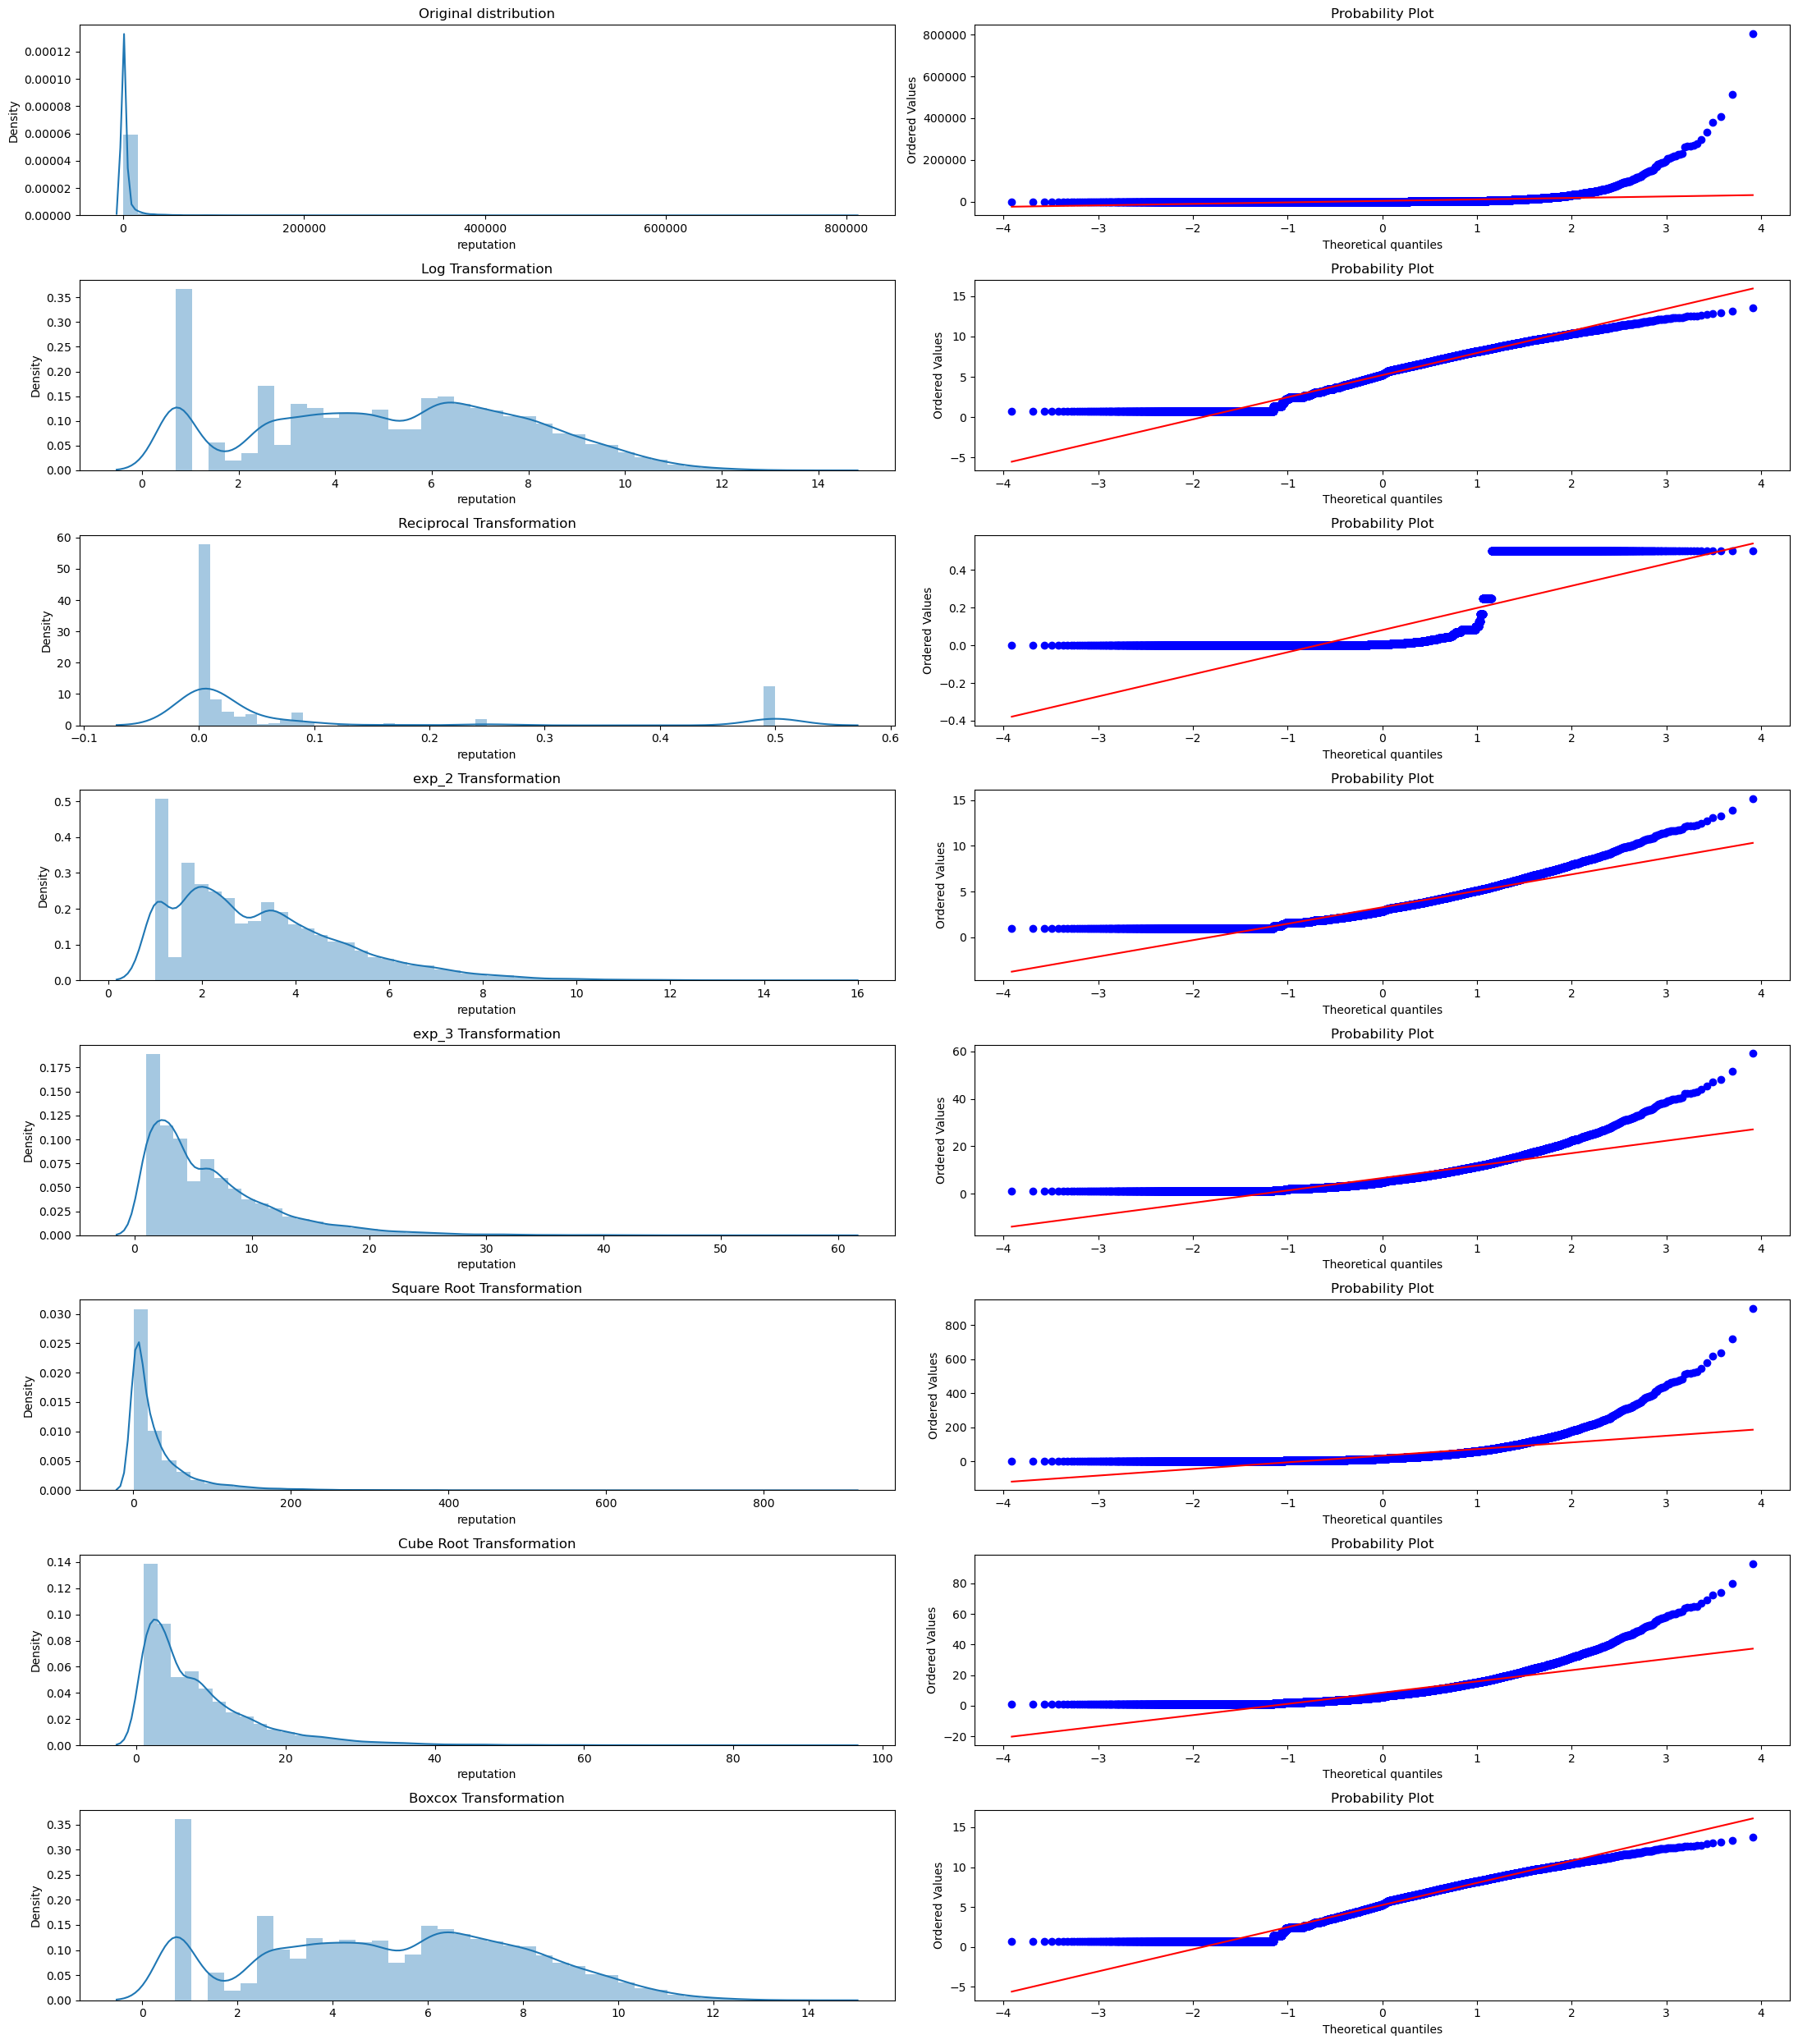

REACHED 

       Transformation      Skew
               Actual 13.478405
                  Log -0.208073
           Reciprocal 30.018070
Exponential power 0.2  1.036488
Exponential power 0.3  1.791763
          Square Root  3.782261
            Cube Root  2.071622
               Boxcox -0.033875

 Best Transformation for  reached : 
 Boxcox = -0.03387487005080541


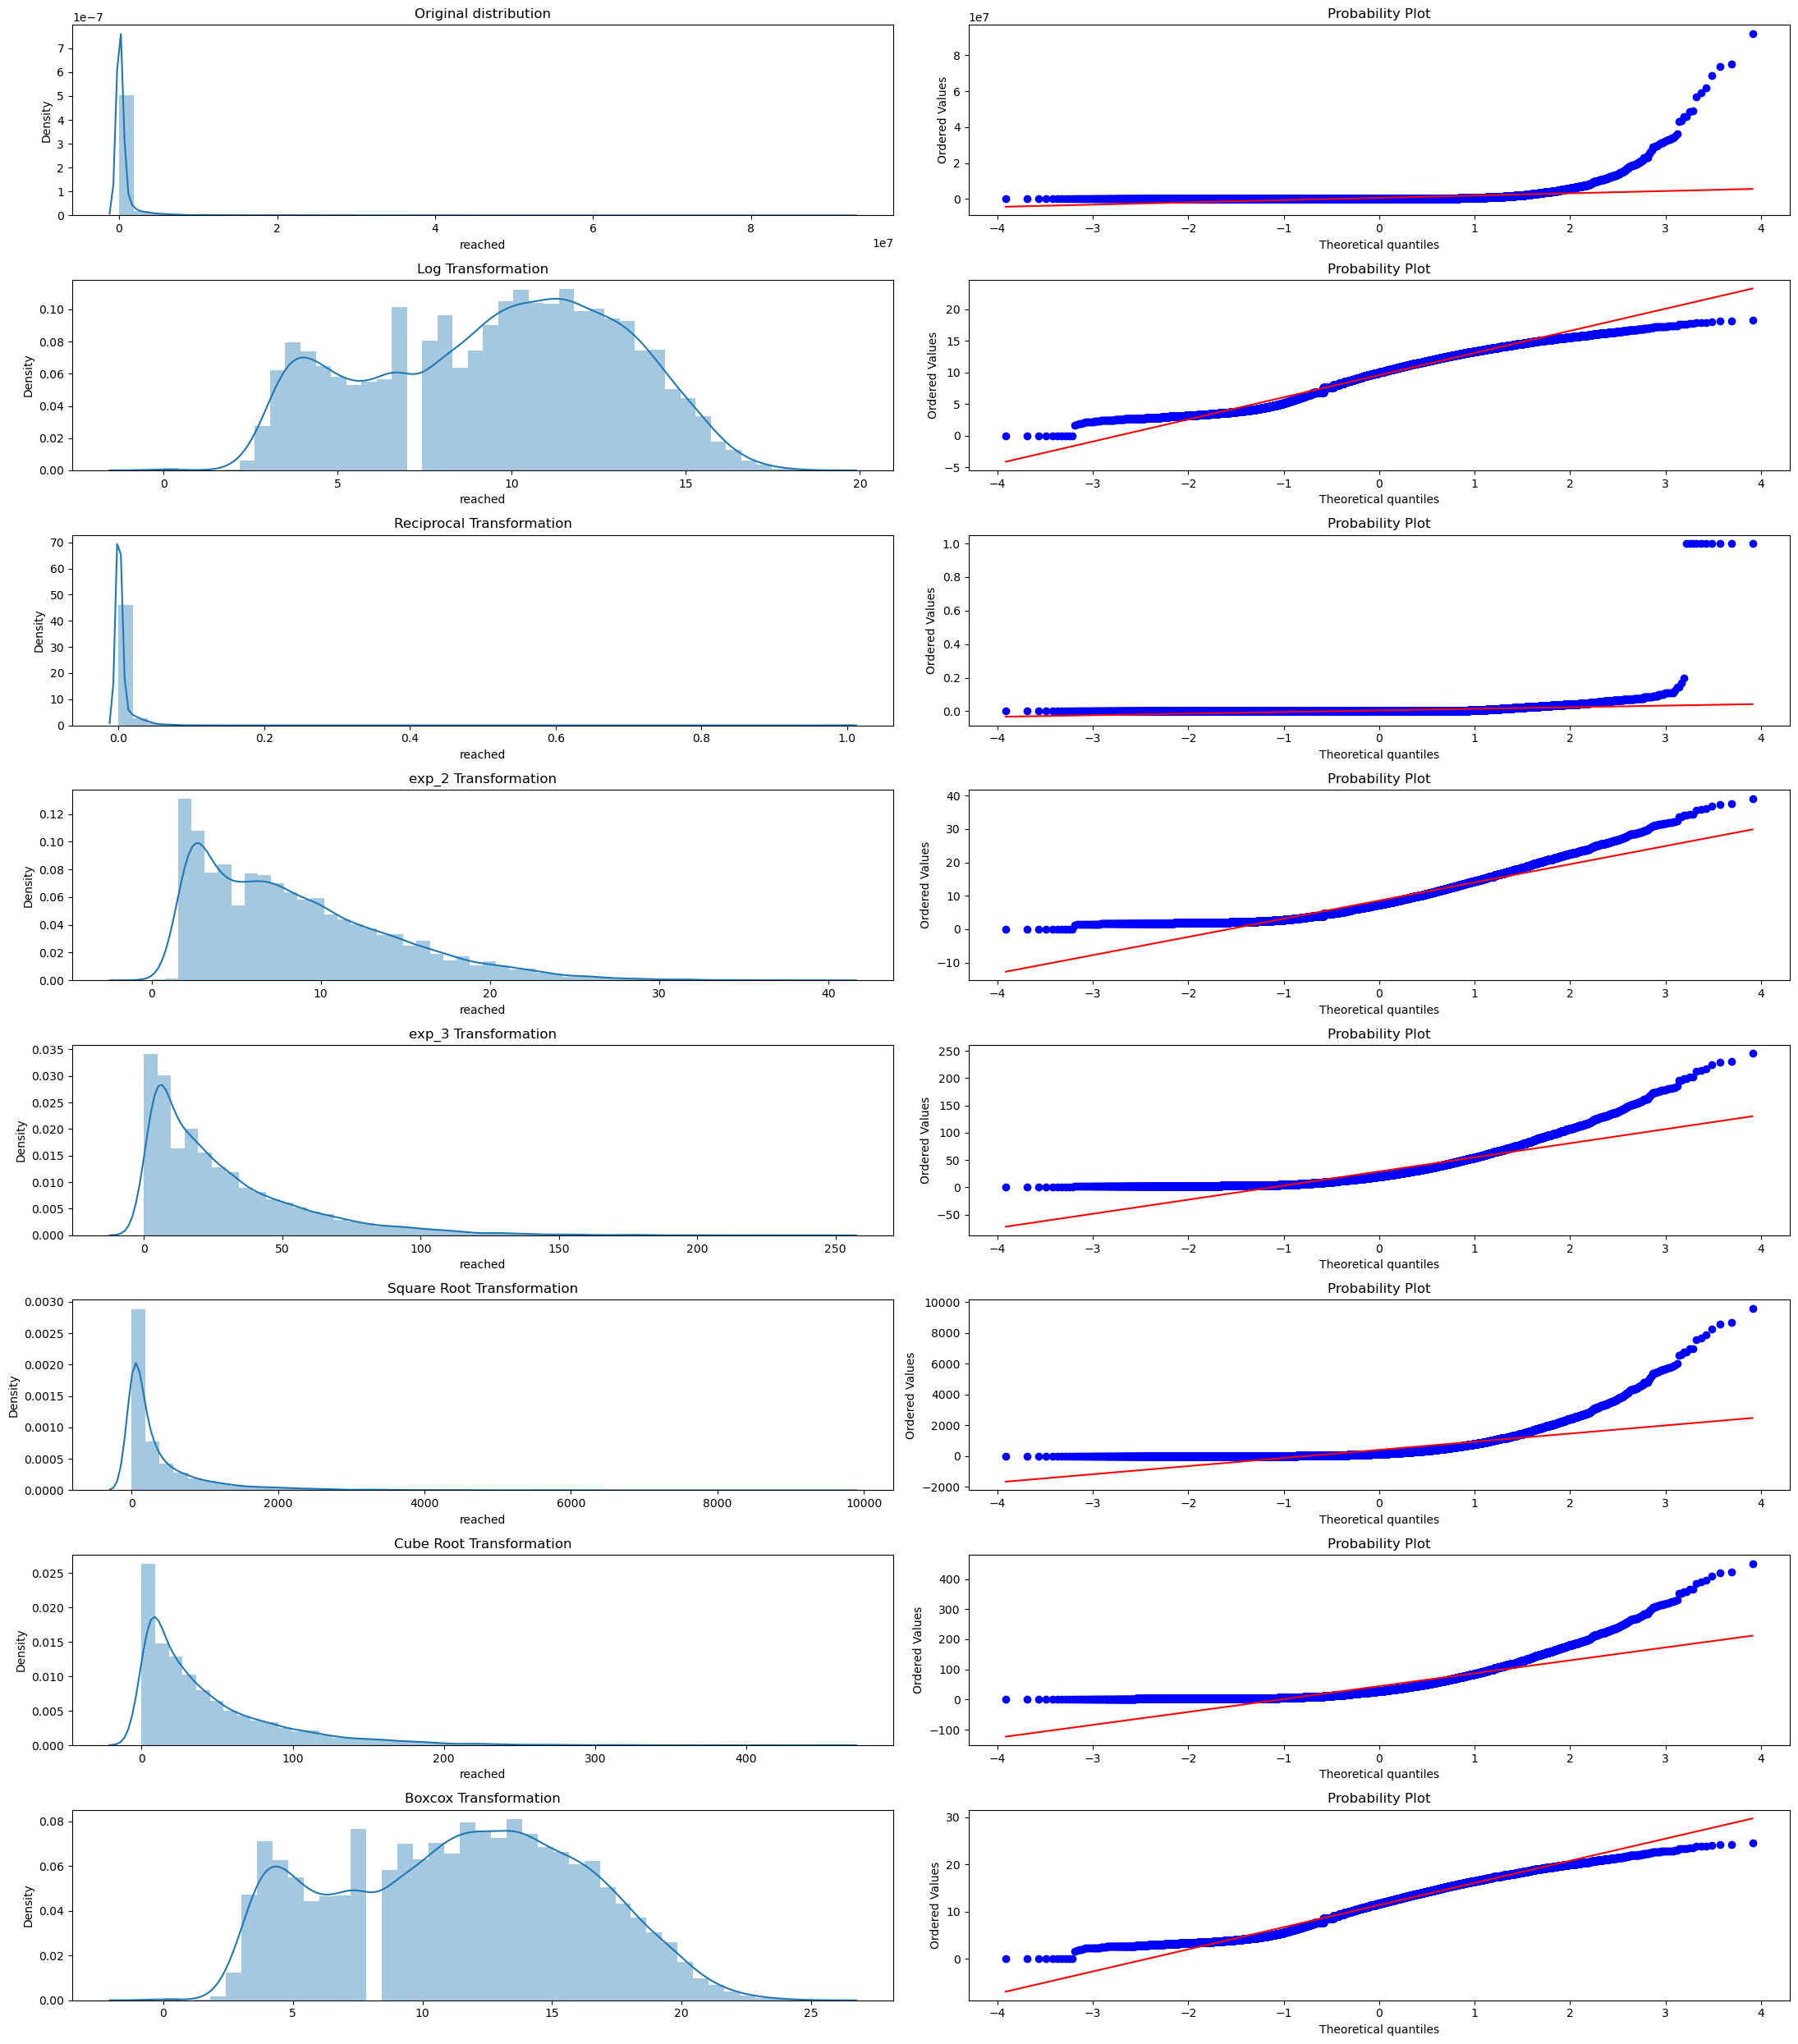

QUESTIONS 

       Transformation     Skew
               Actual 8.026220
                  Log 0.549218
           Reciprocal 1.018573
Exponential power 0.2 1.009518
Exponential power 0.3 1.445720
          Square Root 2.572277
            Cube Root 1.607400
               Boxcox 0.097320

 Best Transformation for  questions : 
 Boxcox = 0.09732047951499985


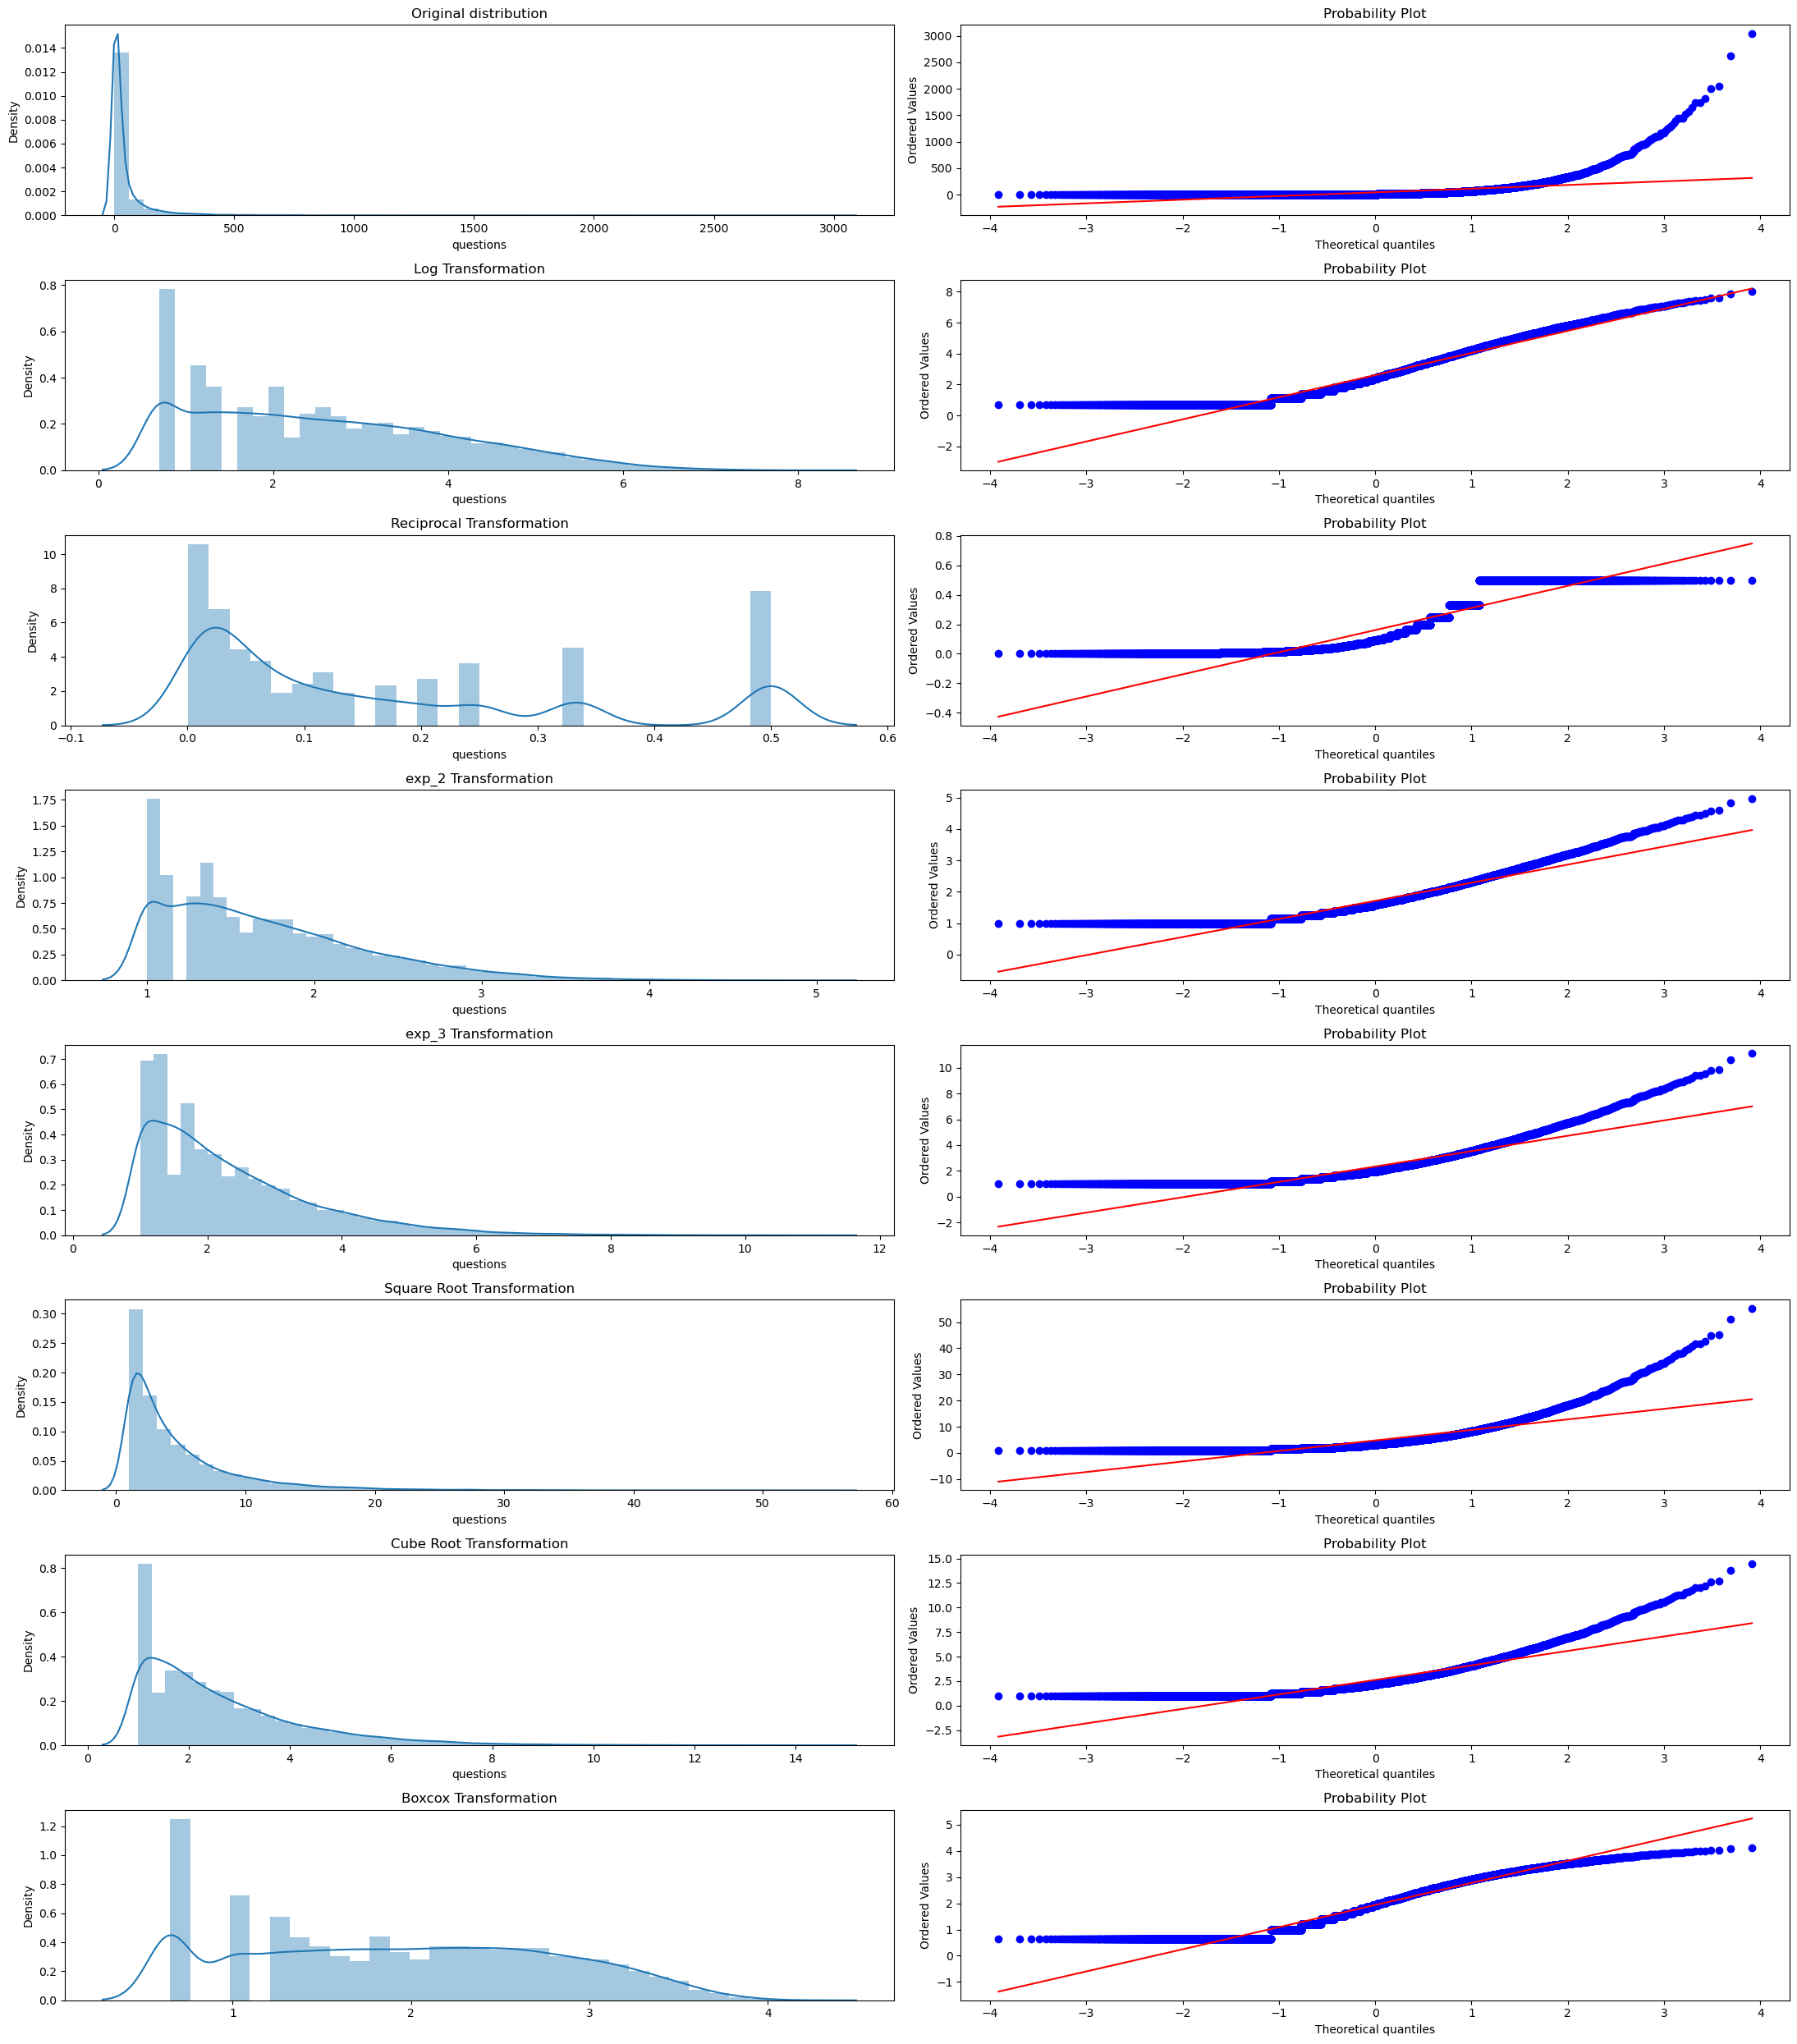

ANSWERS 

       Transformation      Skew
               Actual 20.509819
                  Log  0.826290
           Reciprocal  0.459560
Exponential power 0.2  0.385672
Exponential power 0.3  1.547068
          Square Root  4.816403
            Cube Root  1.991383
               Boxcox  0.206296

 Best Transformation for  answers : 
 Boxcox = 0.20629601374938275


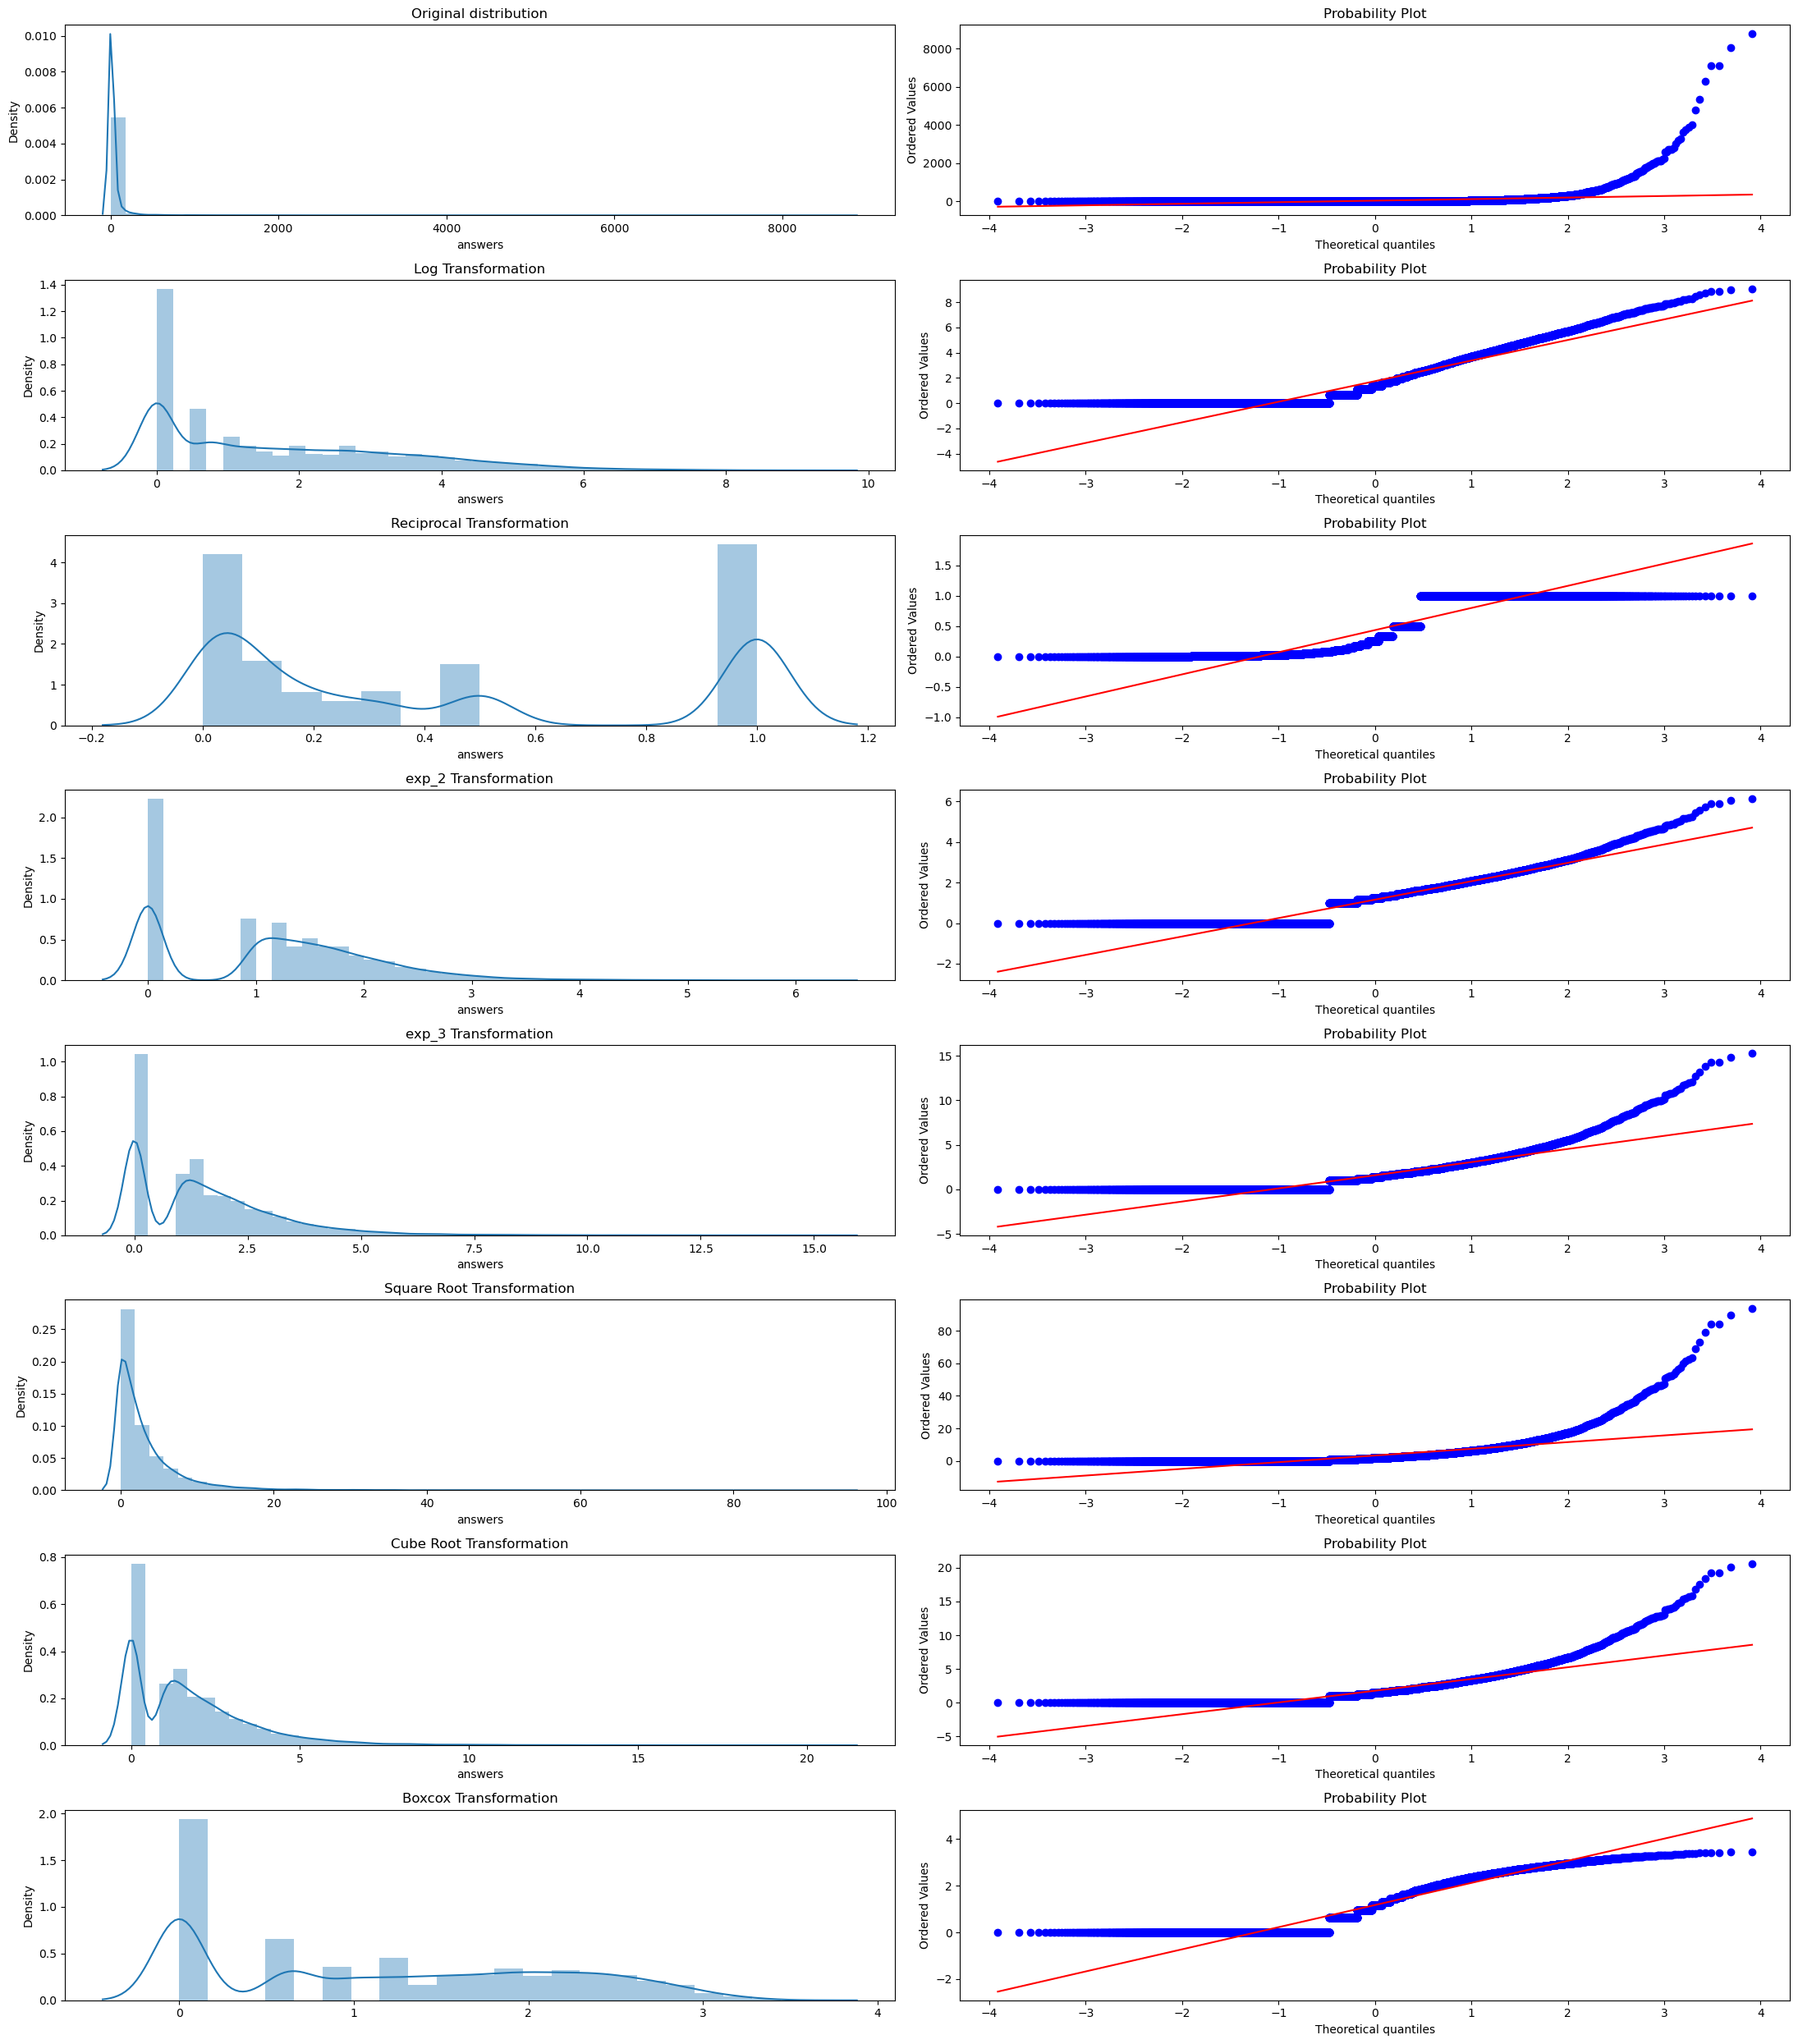

POSTS_EDITED 

       Transformation      Skew
               Actual 34.354018
                  Log  2.657269
           Reciprocal -1.358193
Exponential power 0.2  2.044078
Exponential power 0.3  3.456773
          Square Root  8.911086
            Cube Root  4.106634
               Boxcox  1.255743

 Best Transformation for  posts_edited : 
 Boxcox = 1.2557429448405761


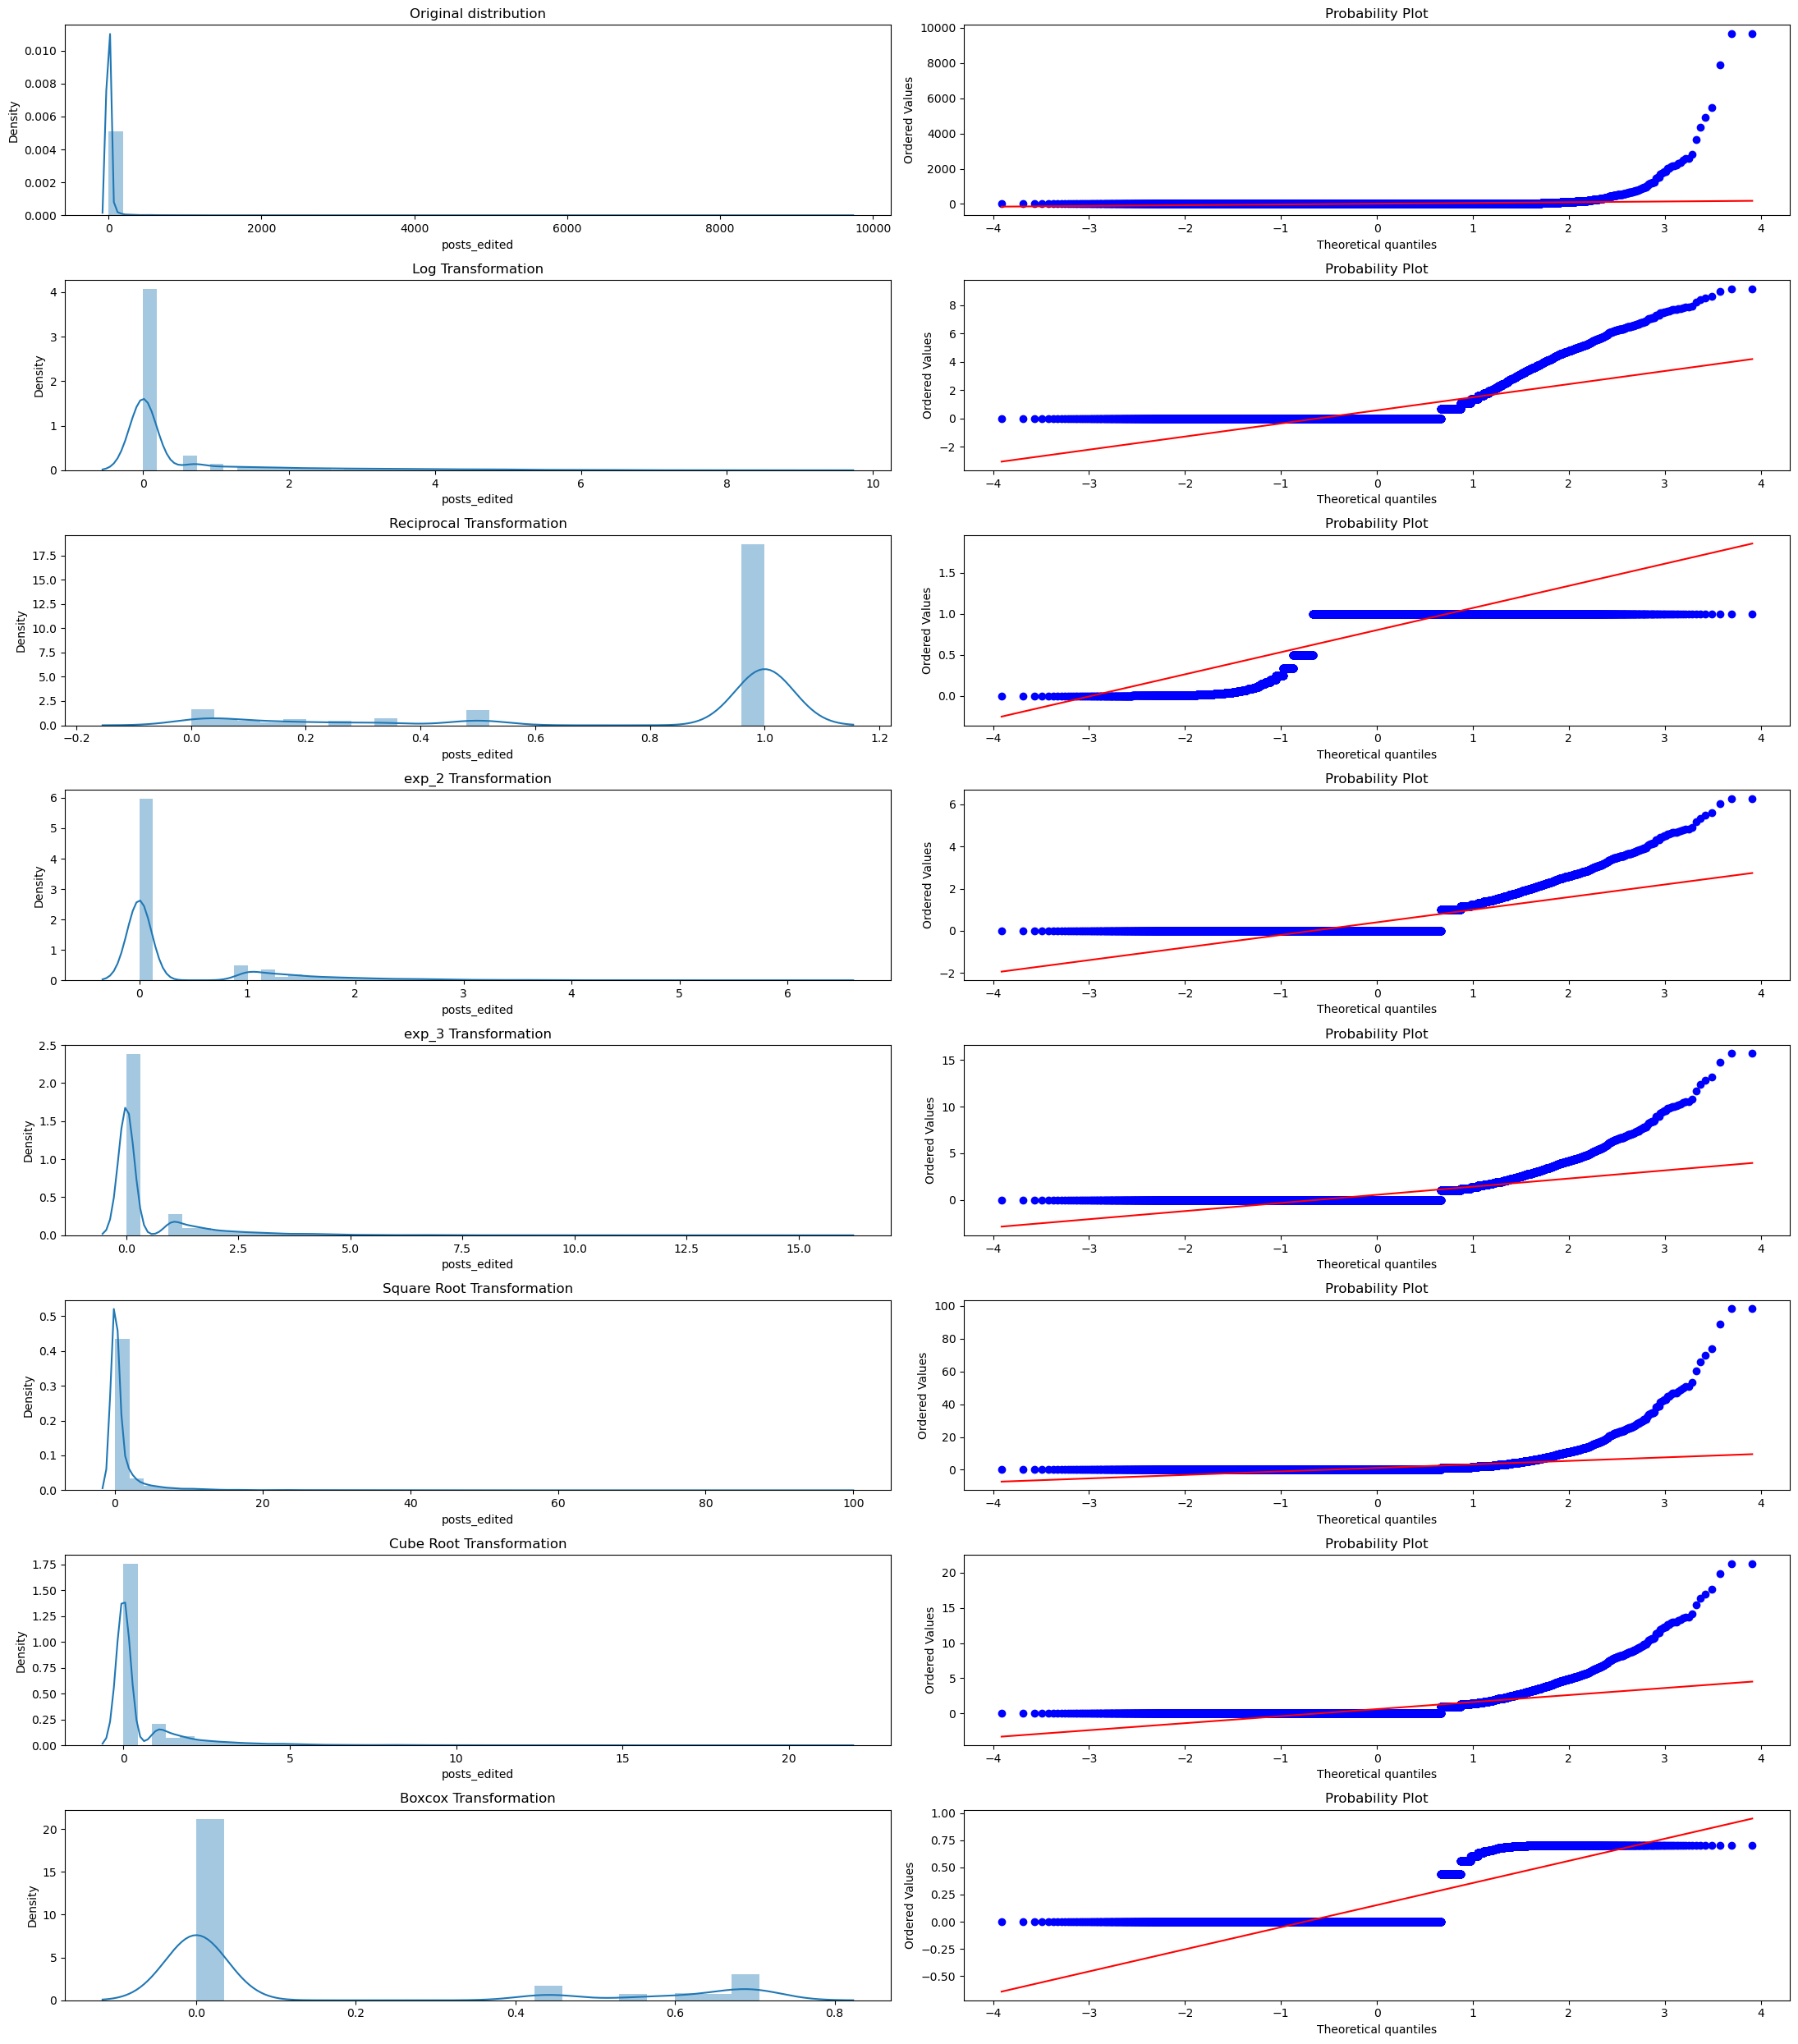

HELPFUL_TAGS 

       Transformation       Skew
               Actual 110.874520
                  Log   3.351118
           Reciprocal  -1.666217
Exponential power 0.2   2.404086
Exponential power 0.3   4.685732
          Square Root  23.619589
            Cube Root   6.067385
               Boxcox   1.457795

 Best Transformation for  helpful_tags : 
 Boxcox = 1.4577952295731875


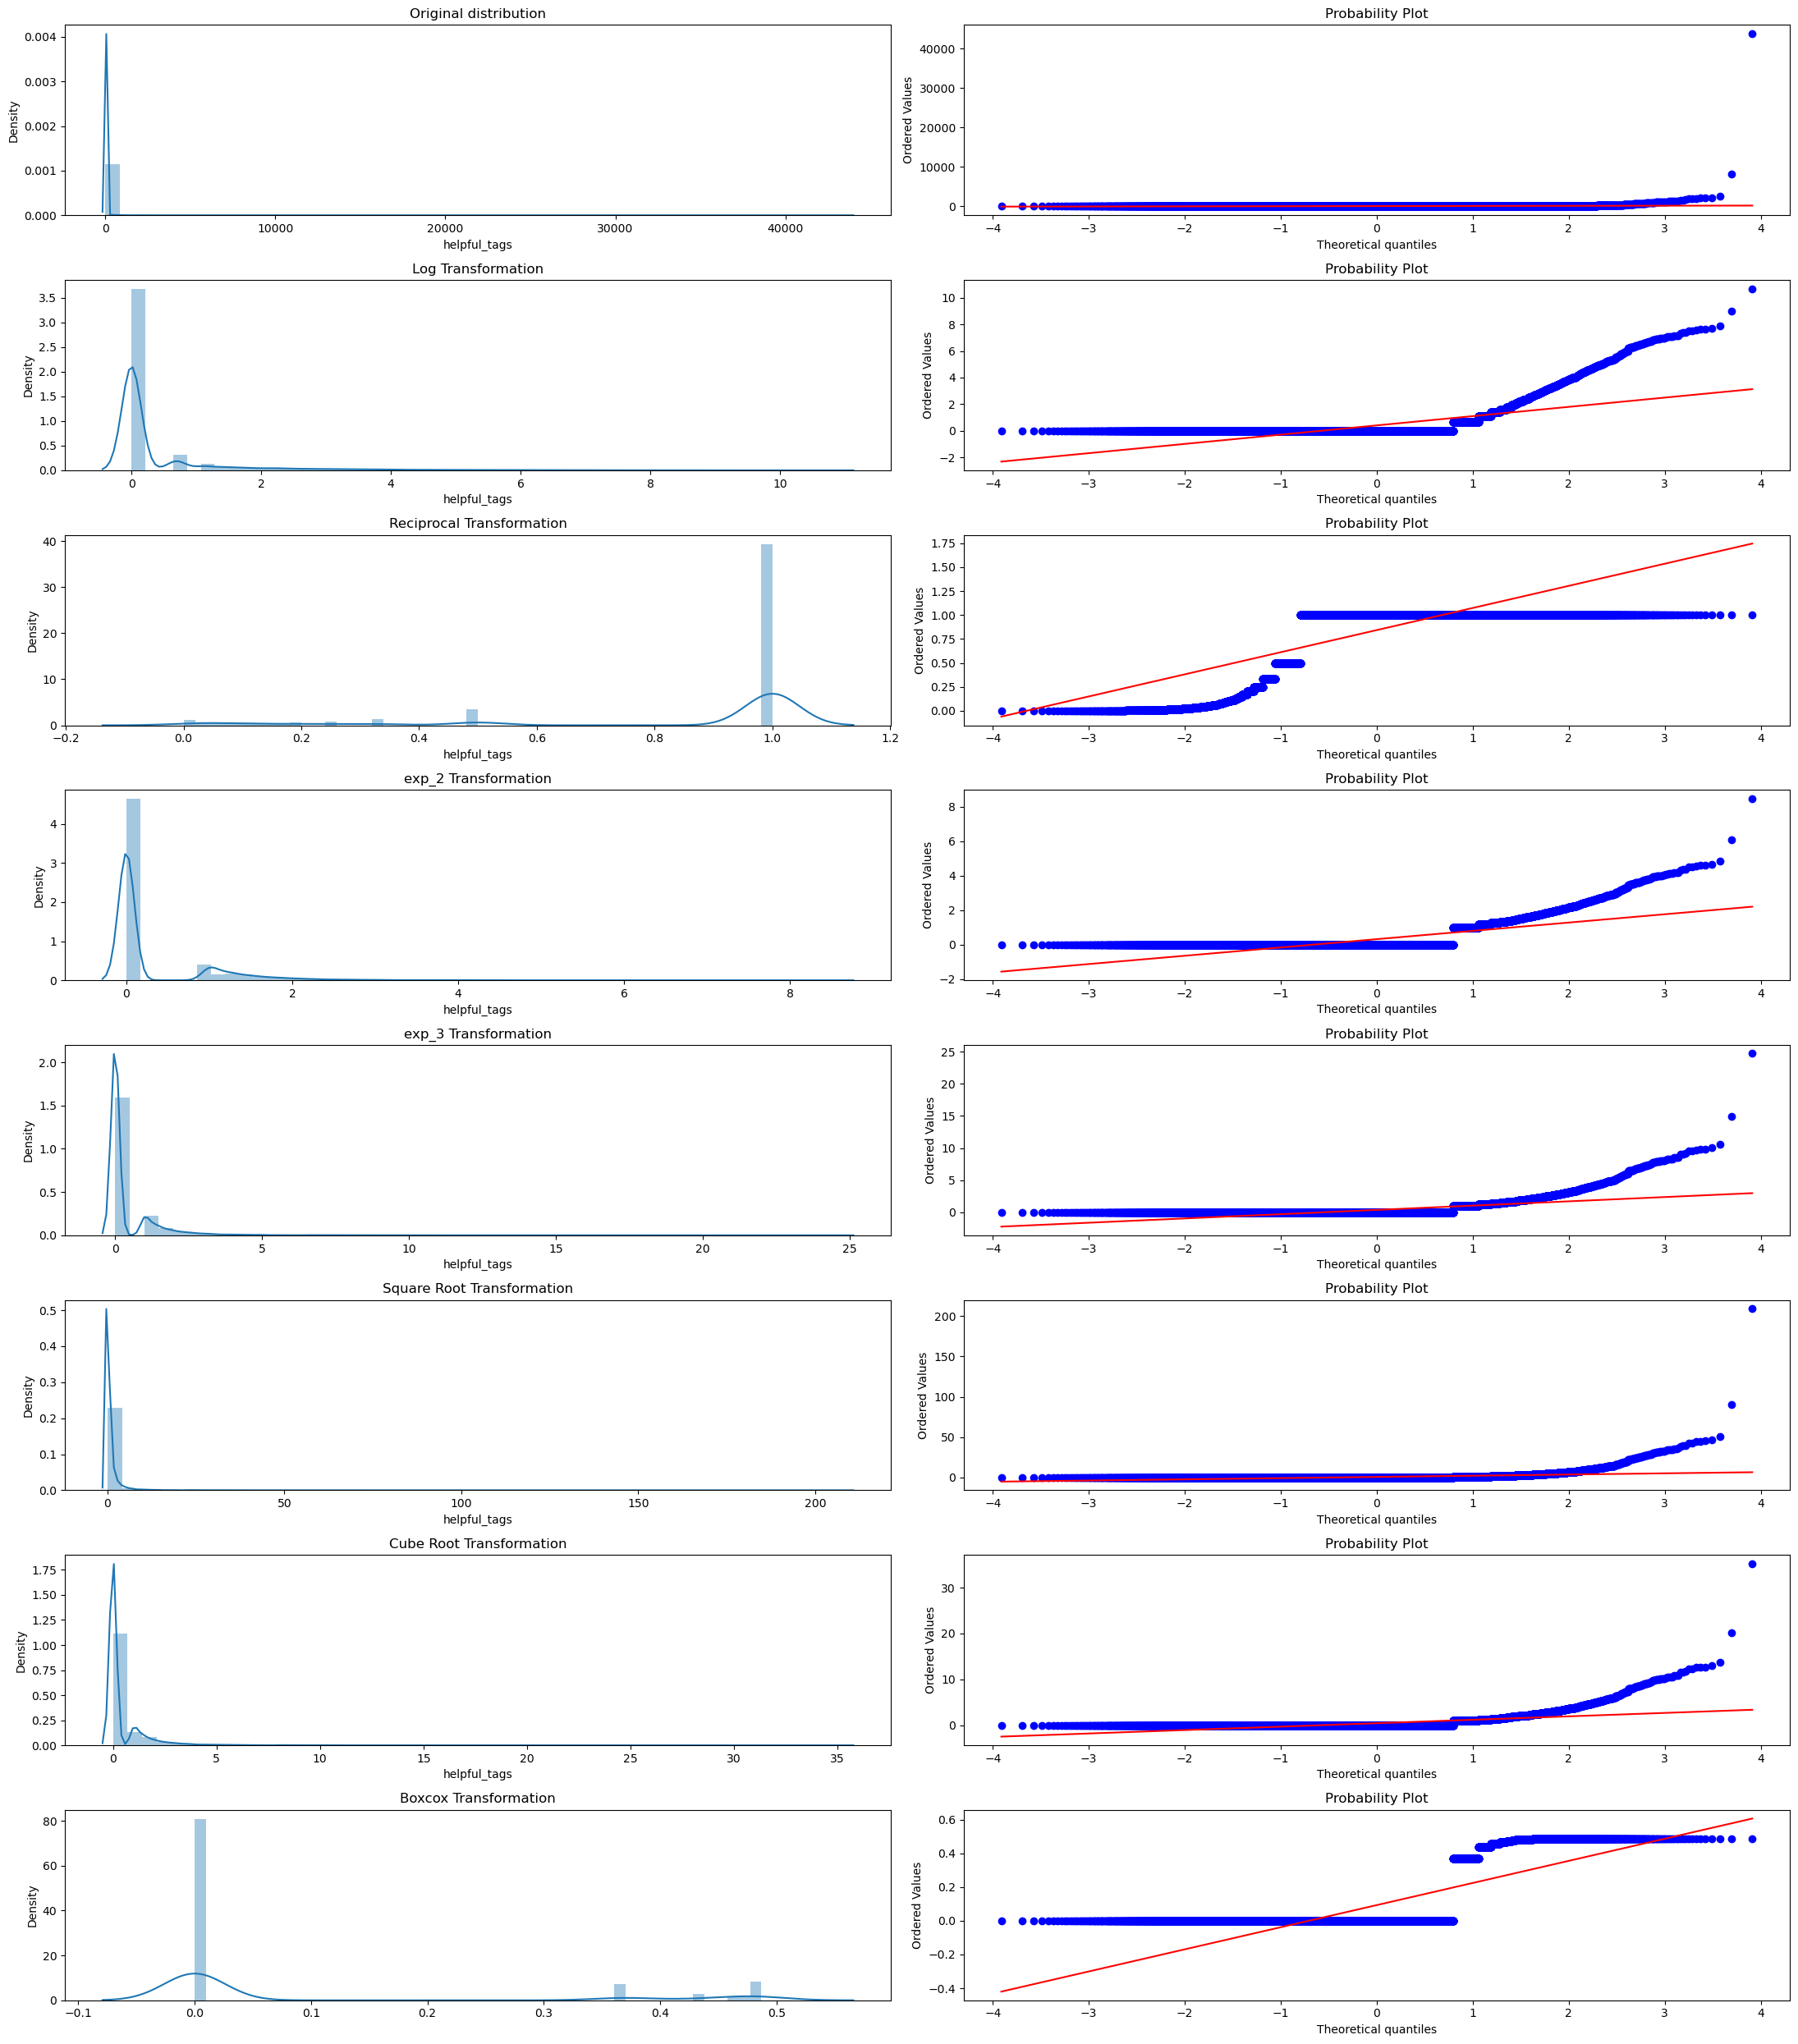

VOTES_CAST 

       Transformation      Skew
               Actual 31.683067
                  Log  0.389665
           Reciprocal  0.697352
Exponential power 0.2  0.480371
Exponential power 0.3  1.375264
          Square Root  3.619012
            Cube Root  1.679457
               Boxcox  0.119060

 Best Transformation for  votes_cast : 
 Boxcox = 0.11906031384467389


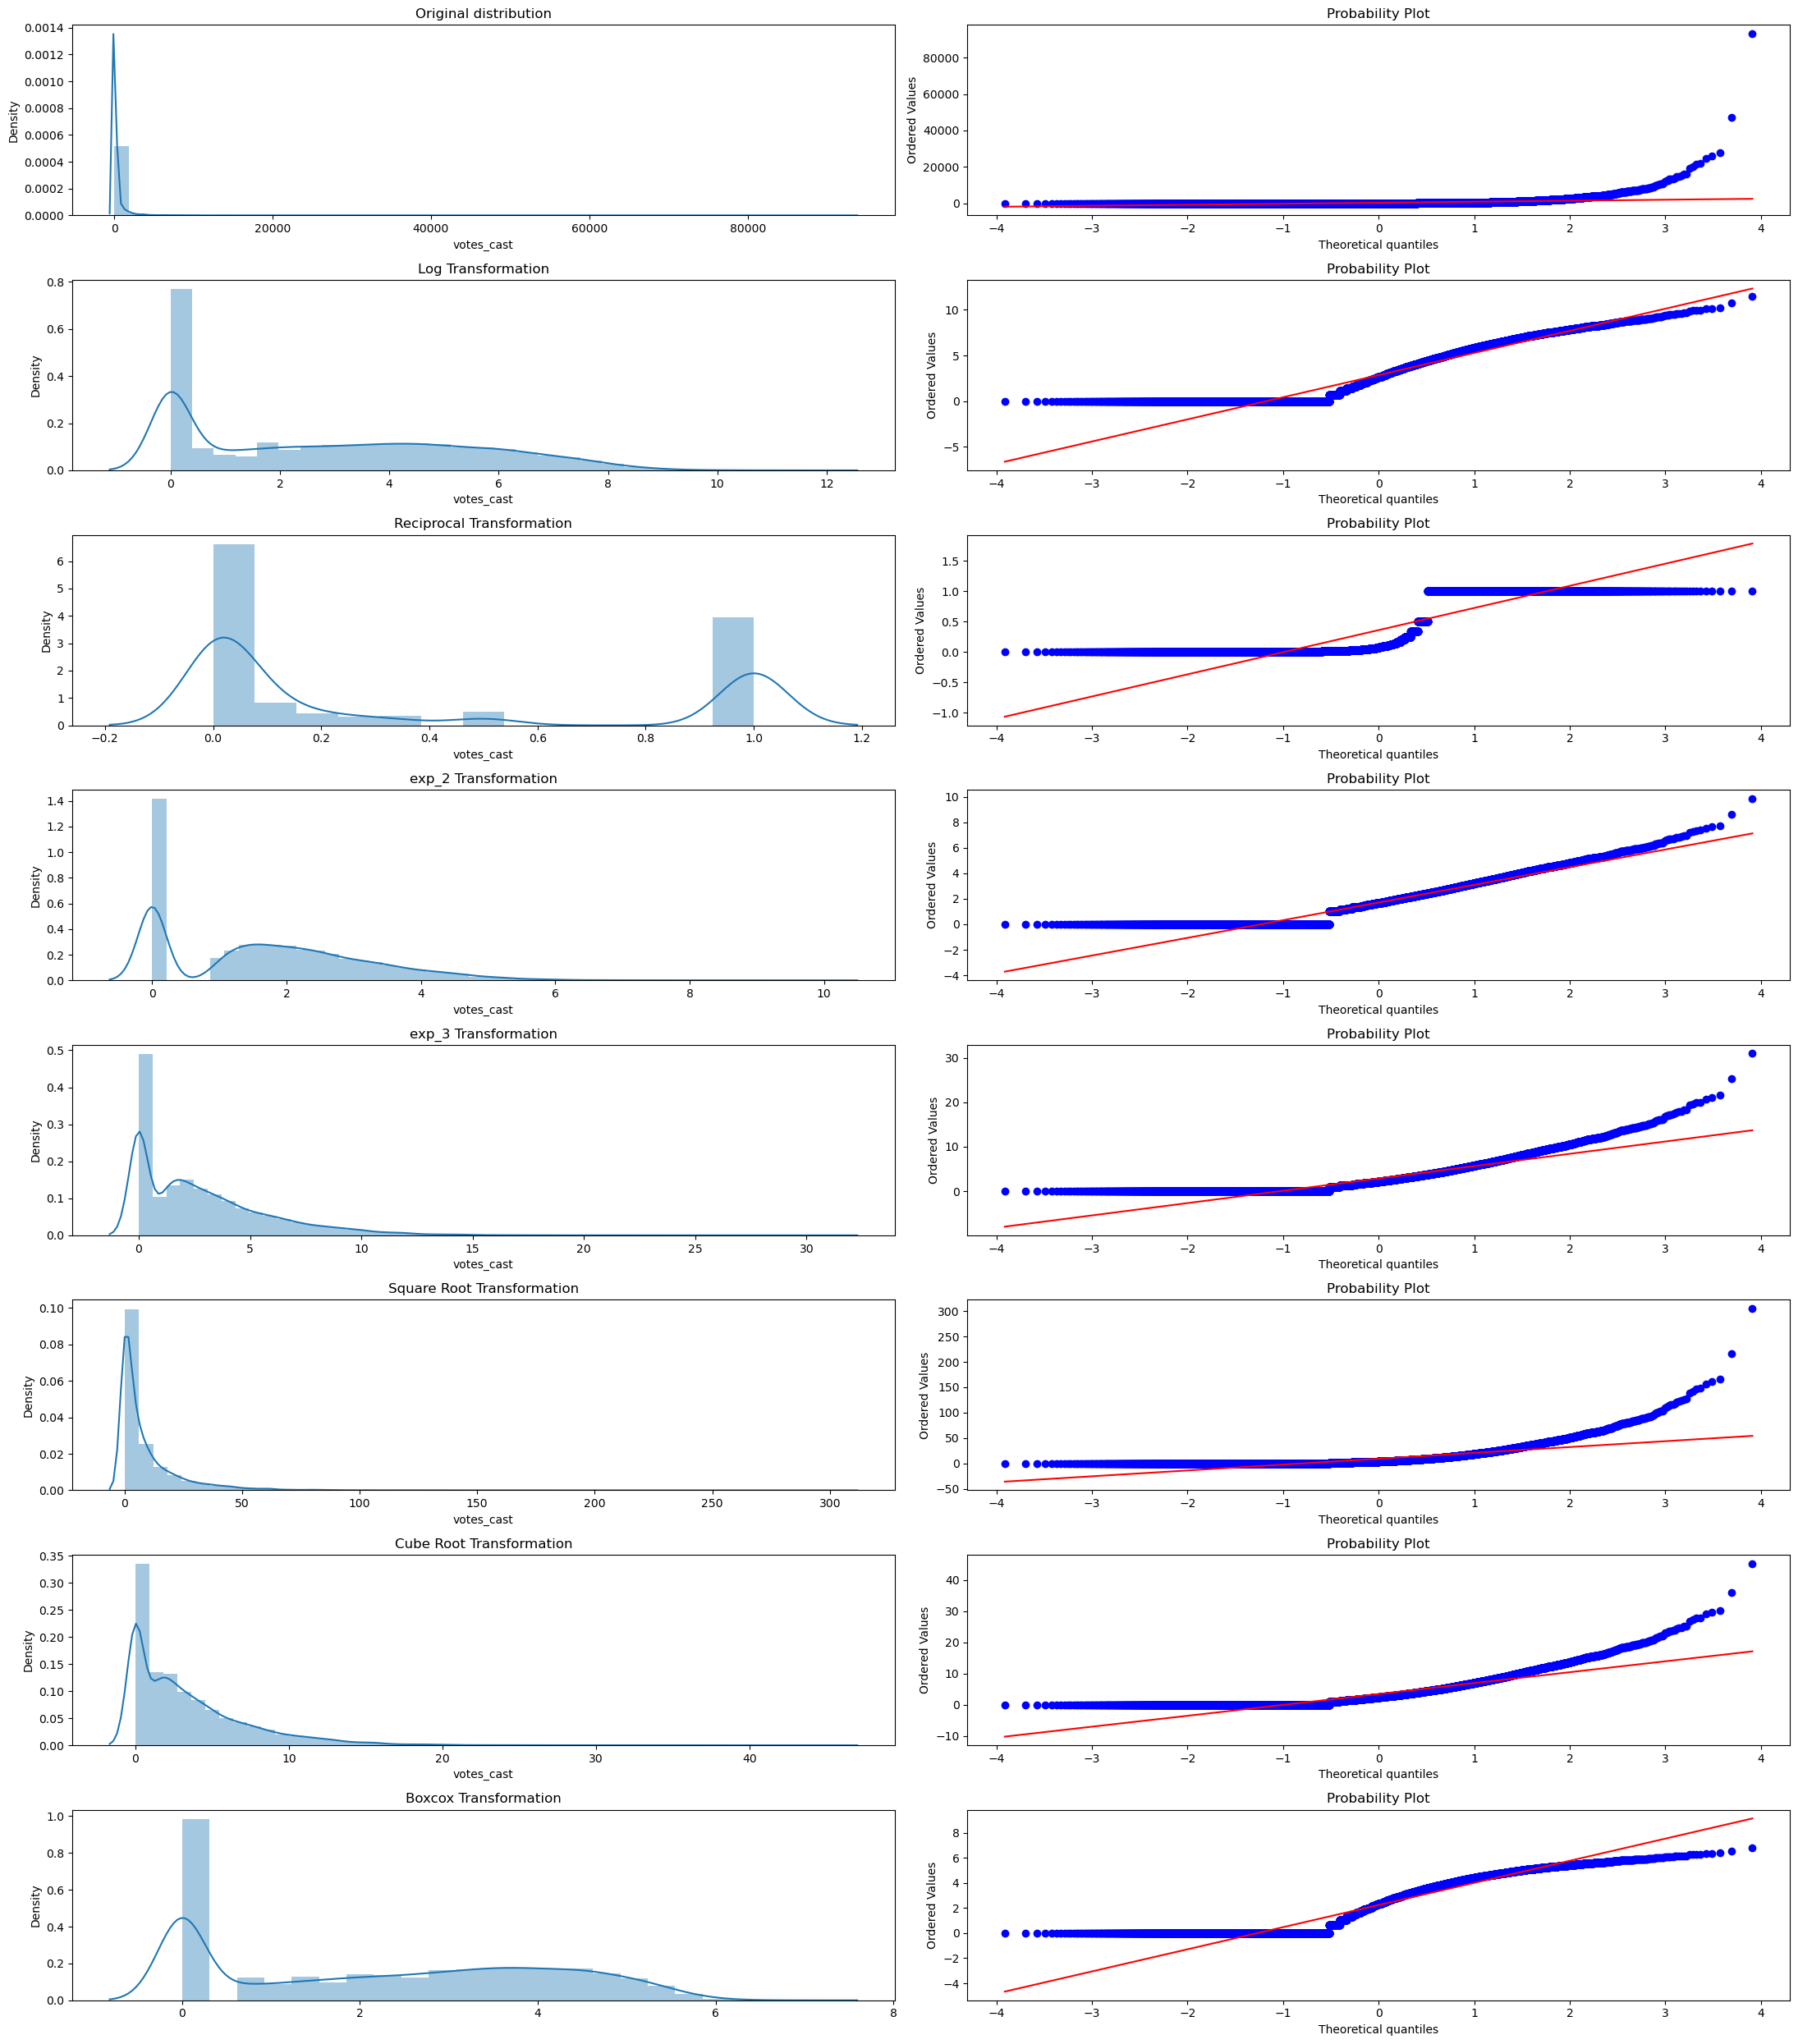

WEIGHTED_BADGE_SCORE 

       Transformation      Skew
               Actual  7.636469
                  Log -0.052680
           Reciprocal  3.623381
Exponential power 0.2 -0.148090
Exponential power 0.3  0.973642
          Square Root  2.486765
            Cube Root  1.251558
               Boxcox  0.000277

 Best Transformation for  weighted_badge_score : 
 Boxcox = 0.00027689228391577575


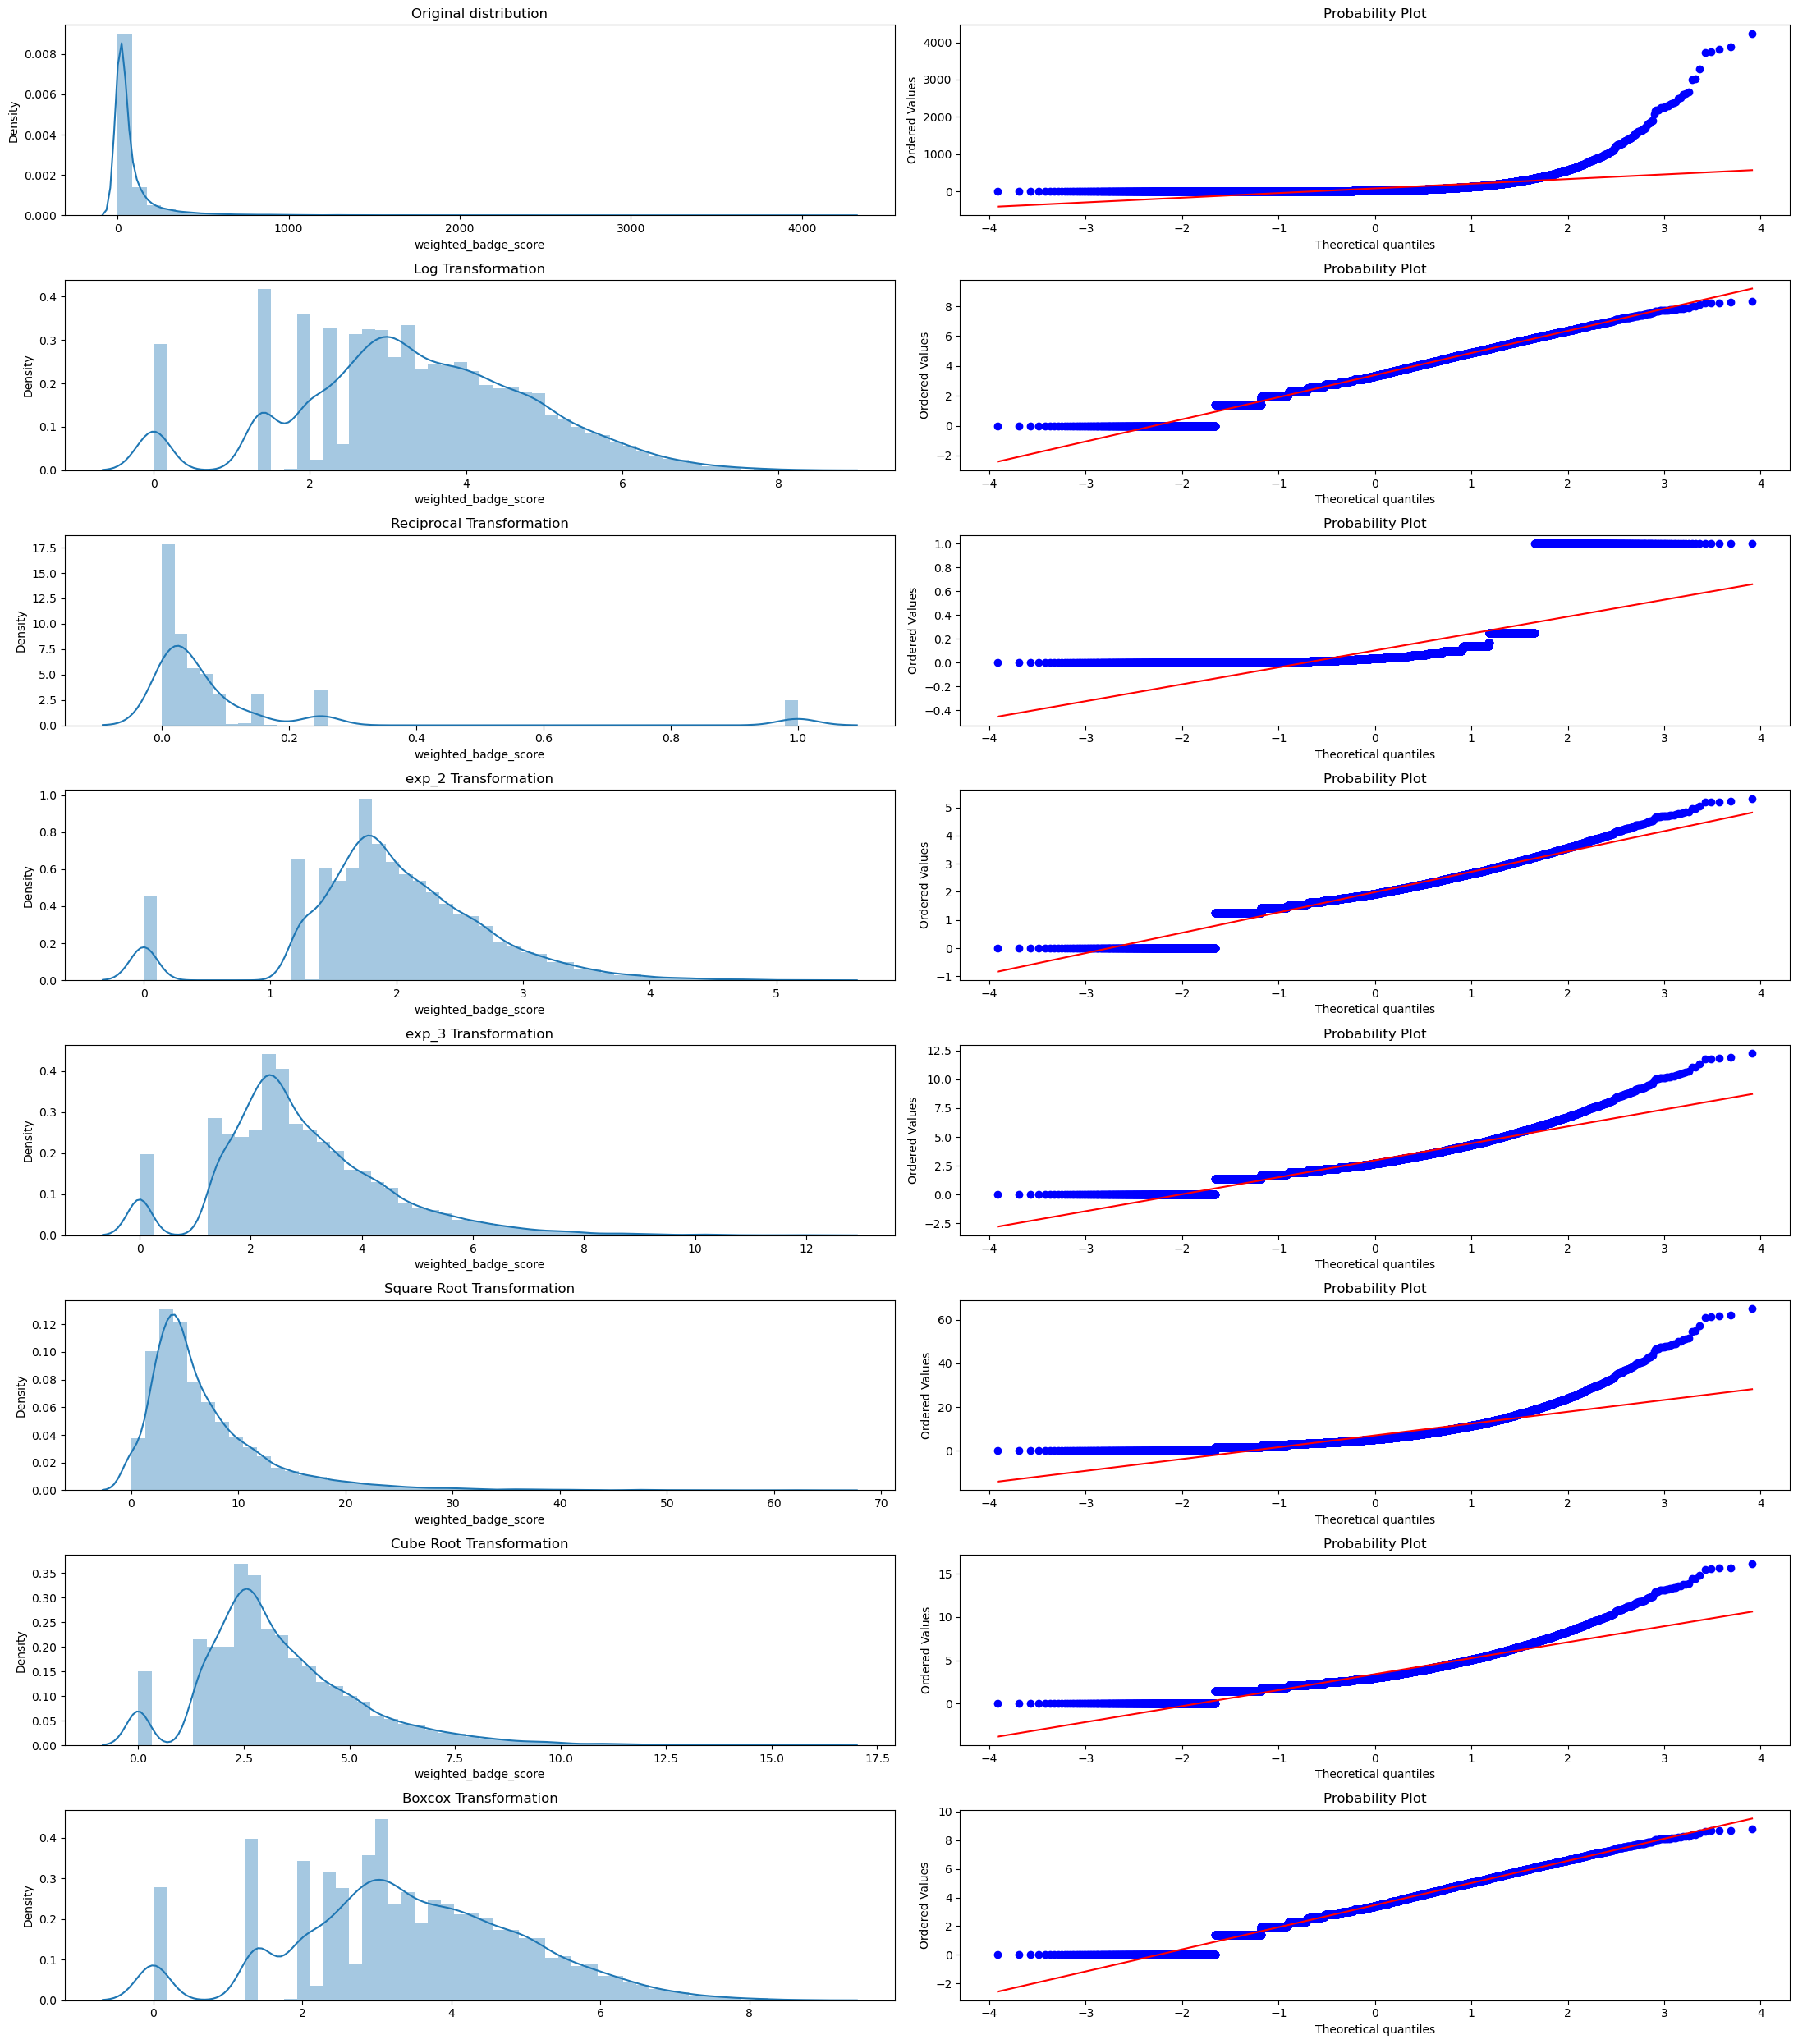

QA_RATIO 

       Transformation      Skew
               Actual 40.310181
                  Log  2.772741
           Reciprocal -0.947132
Exponential power 0.2  0.230025
Exponential power 0.3  1.566566
          Square Root  7.070324
            Cube Root  2.172763
               Boxcox  0.569230

 Best Transformation for  QA_ratio : 
 Exponential power 0.2 = 0.2300250656051421


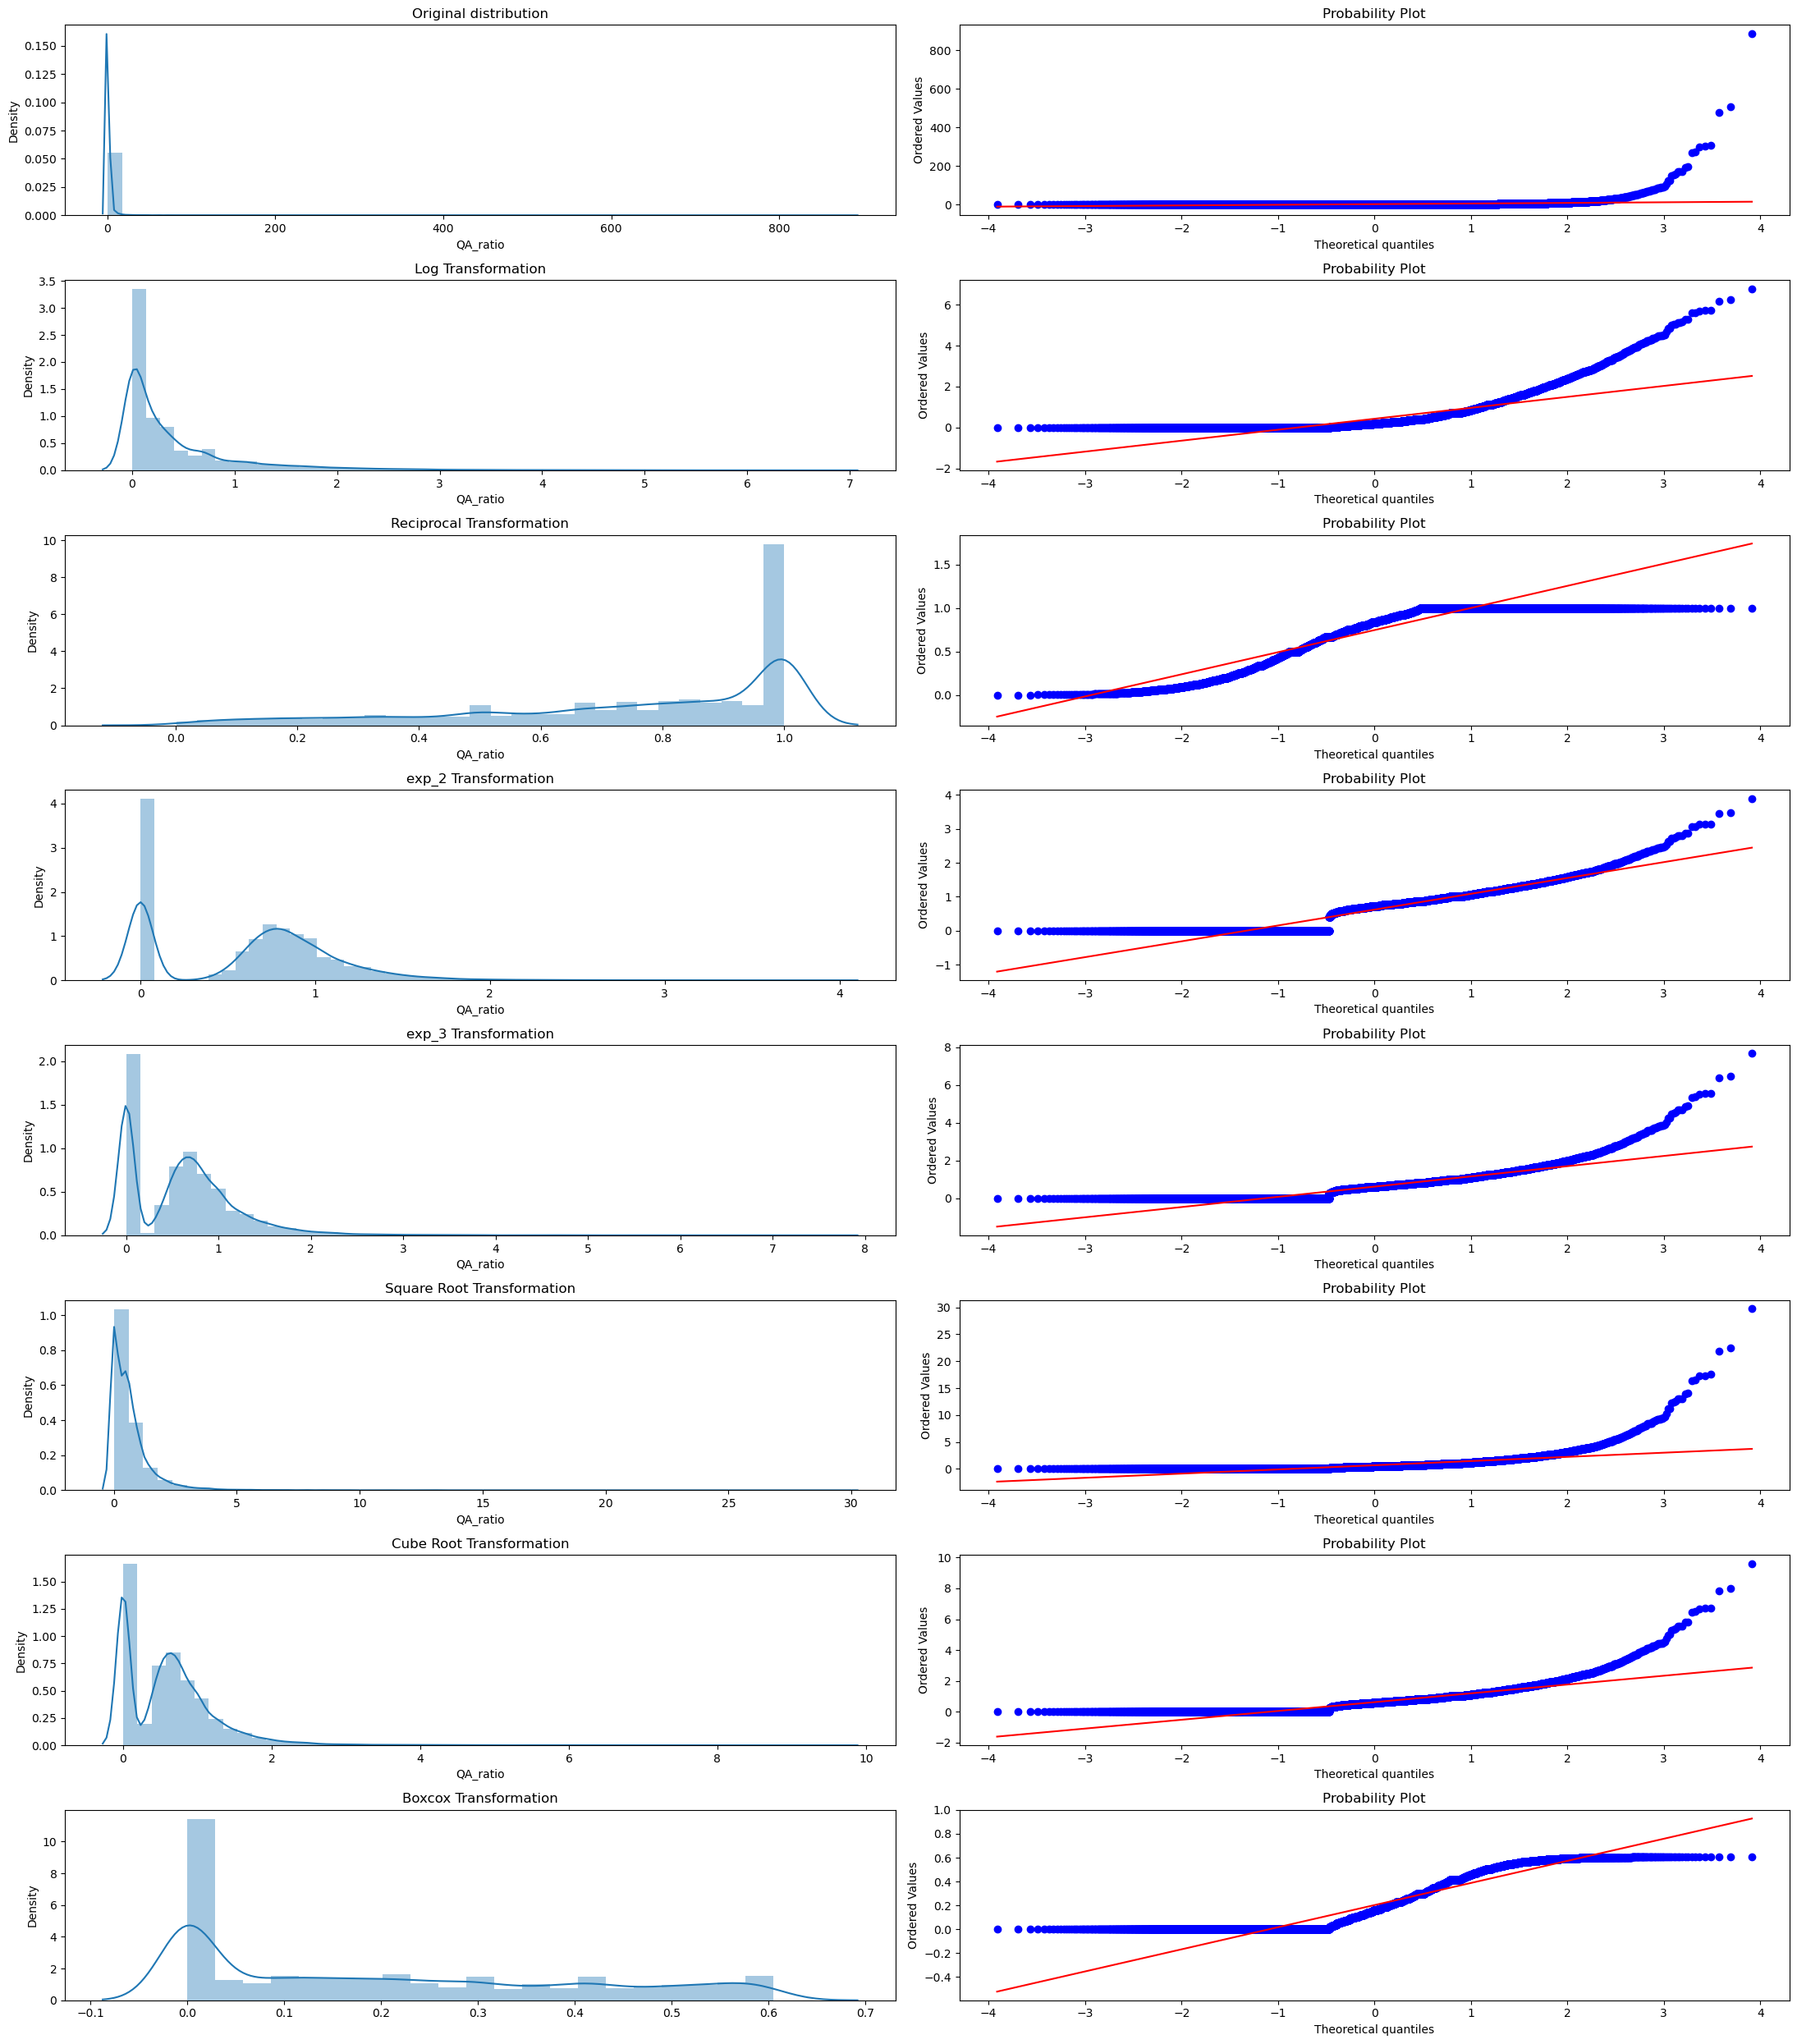

In [42]:
for column in ['reputation', 'reached', 'questions', 'answers',
        'posts_edited', 'helpful_tags', 'votes_cast',
        'weighted_badge_score', 'QA_ratio']:
    
    print('\033[1m'+column.upper()+'\033[0m','\n')
    plt.figure(figsize=(22,25))
    
    raw_skewness = df_train[column].skew()
    
    plt.subplot(8,2,1)
    sns.distplot(df_train[column])
    plt.title('Original distribution')
    
    plt.subplot(8,2,2)
    st.probplot(df_train[column],dist='norm',plot=plt)
    
    
    #log transformation
    log_transform = np.log(df_train[column]+1)
    log_skew=log_transform.skew()

    plt.subplot(8,2,3)
    sns.distplot(log_transform)
    plt.title('Log Transformation')

    plt.subplot(8,2,4)
    st.probplot(log_transform,dist='norm',plot=plt)
    
    #Reciprocal Transformation  
    recip_transform = 1/(df_train[column]+1)
    recip_skew=recip_transform.skew()

    plt.subplot(8,2,5)
    sns.distplot(recip_transform)
    plt.title('Reciprocal Transformation')

    plt.subplot(8,2,6)
    st.probplot(recip_transform,dist='norm',plot=plt)
    
    #Exponential Transformation
    
    exp_2 = df_train[column]**0.2
    exp_2_skew=exp_2.skew()
    
    plt.subplot(8,2,7)
    sns.distplot(exp_2)
    plt.title('exp_2 Transformation')
    
    plt.subplot(8,2,8)
    st.probplot(exp_2,dist='norm',plot=plt)
    
    exp_3 = df_train[column]**0.3
    exp_3_skew=exp_3.skew()
    
    plt.subplot(8,2,9)
    sns.distplot(exp_3)
    plt.title('exp_3 Transformation')
    
    plt.subplot(8,2,10)
    st.probplot(exp_3,dist='norm',plot=plt)
    
    #Square Root Transformation
    
    sqrt_transform = df_train[column]**(1/2)
    sqrt_transform_skew=sqrt_transform.skew()
    
    plt.subplot(8,2,11)
    sns.distplot(sqrt_transform)
    plt.title('Square Root Transformation')
    
    plt.subplot(8,2,12)
    st.probplot(sqrt_transform,dist='norm',plot=plt)
    
    #Cube Root Transformation
    
    cube_transform = df_train[column]**(1/3)
    cube_transform_skew=cube_transform.skew()
    
    plt.subplot(8,2,13)
    sns.distplot(cube_transform)
    plt.title('Cube Root Transformation')
    
    plt.subplot(8,2,14)
    st.probplot(cube_transform,dist='norm',plot=plt)
    
    #Boxcox Transformation
    box,param = st.boxcox(df_train[column]+1)
    boxcox_skew=pd.DataFrame(box).skew()

    plt.subplot(8,2,15)
    plt.tight_layout()
    sns.distplot(pd.DataFrame(box))
    plt.title('Boxcox Transformation')

    plt.subplot(8,2,16)
    st.probplot(box,dist='norm',plot=plt)
    
    trans_result= {'Actual':raw_skewness, 'Log':log_skew,'Reciprocal':recip_skew,'Exponential power 0.2':exp_2_skew,
                       'Exponential power 0.3':exp_3_skew,'Square Root':sqrt_transform_skew,
                       'Cube Root':cube_transform_skew,'Boxcox':boxcox_skew[0]}
    print(pd.DataFrame(trans_result.items(), columns=['Transformation', 'Skew']).to_string(index=False))
    
    lst=list(trans_result.values())
    idx = min((abs(x), x) for x in lst)[1]
    for i in trans_result:
        if (trans_result[i]==idx):
            print('\n','Best Transformation for ',column,':','\n',i,'=',trans_result[i])
    plt.tight_layout() 
    
    plt.show()

In [43]:
df_train['reputation_st'],rep = st.boxcox(df_train['reputation']+1)
df_train['reached_st'],reach = st.boxcox(df_train['reached']+1)
df_train['questions_st'],ques = st.boxcox(df_train['questions']+1)
df_train['answers_st'],ans = st.boxcox(df_train['answers']+1)
df_train['posts_edited_st'],post = st.boxcox(df_train['posts_edited']+1)
df_train['helpful_tags_st'],help = st.boxcox(df_train['helpful_tags']+1)
df_train['votes_cast_st'],vote = st.boxcox(df_train['votes_cast']+1)
df_train['weighted_badge_score_st'],badge = st.boxcox(df_train['weighted_badge_score']+1)
df_train['QA_ratio_st'] = df_train['QA_ratio']**0.2

## Scaling with Robust Scaler

In [44]:
st_columns = [i for i in df_train.columns if i.endswith('_st')]
scaler = RobustScaler()
df_train[st_columns] = scaler.fit_transform(df_train[st_columns])
scaled2 = scaler.fit_transform(df_train[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_train.index)
df_train = pd.concat([df_train, df_scaled2], axis=1)

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [46]:
st_columns1 = [i for i in df_train.columns if i.endswith('_st')]
calc_vif(df_train[st_columns1])

variables        VIF
0                     reputation_st  15.168006
1                        reached_st  11.630759
2                      questions_st   7.011537
3                        answers_st  14.132618
4                   posts_edited_st   2.909490
5                   helpful_tags_st   2.333019
6                     votes_cast_st   6.011432
7           weighted_badge_score_st  11.591949
8                       QA_ratio_st   6.760466
9         member_since_in_months_st   2.798391
10  total_requirements_satisfied_st   1.119877

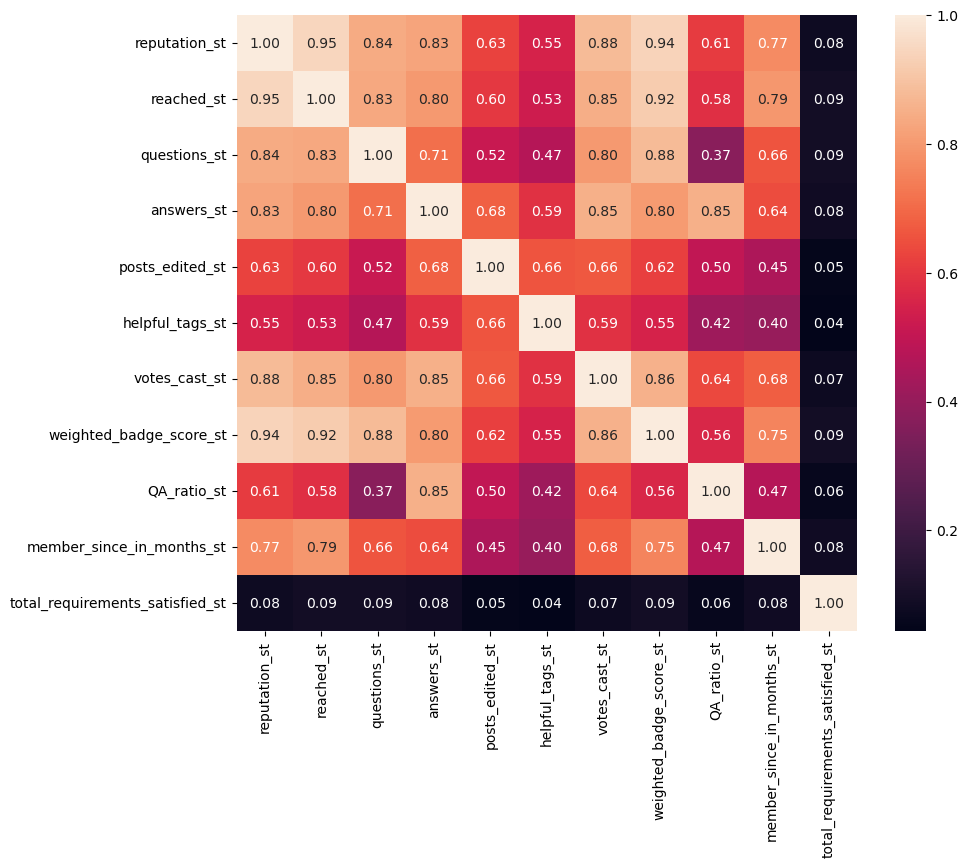

In [47]:
corr_matrix = df_train[st_columns1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

## Modelling

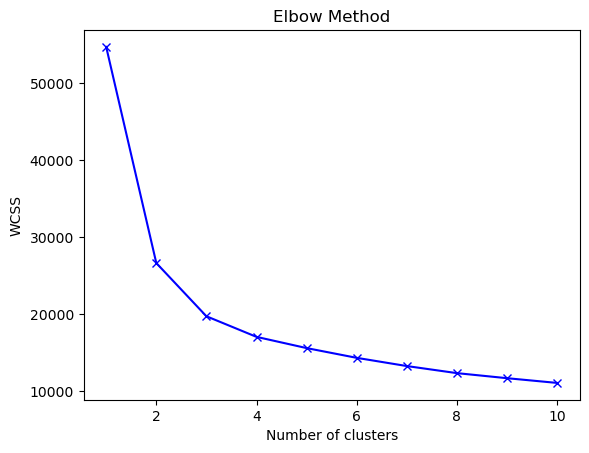

In [50]:
# kmodel.drop(columns='Cluster',inplace=True)
from sklearn.cluster import KMeans
kmodel = df_train.copy()
wcss = []
results = []

for i in range(1, 11):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(kmodel[st_columns1])  # X is your data
    wcss.append(kmeans.inertia_)
    results.append({'Number of Clusters': i, 'WCSS': kmeans.inertia_})
    
elbow_data = pd.DataFrame(results)
    
plt.plot(range(1, 11), wcss, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [51]:
elbow_data

Number of Clusters          WCSS
0                   1  54681.010730
1                   2  26655.445884
2                   3  19753.627863
3                   4  17080.117457
4                   5  15625.114870
5                   6  14360.286758
6                   7  13294.931130
7                   8  12376.961881
8                   9  11721.226510
9                  10  11107.935209

In [52]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(kmodel[st_columns1])
kmodel['Cluster'] = kmeans.labels_
kmodel_inference = kmodel[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]


In [53]:
kmodel_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0          14388.77  2576641.07     136.30   163.90         74.58   
1              7.95      527.10       2.06     0.16          0.00   
2           1746.58   296911.88      48.97    14.65          0.22   
3            127.28    18992.38       8.52     2.31          0.18   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0               51.01     1161.74                  134.11   
1                0.01        0.16                   21.75   
2                0.48      140.89                  115.62   
3                0.25       13.43                   69.30   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                      279.53      5.03                          1.32  
1                        5.09      0.11                          1.18  
2                       77.06      0.91                          1.30  
3                       19.28      0.64                          1.25

In [54]:
kmodel_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        3              4413
1        2              3881
2        1              3615
3        0              3229

## Visualizing Clusters

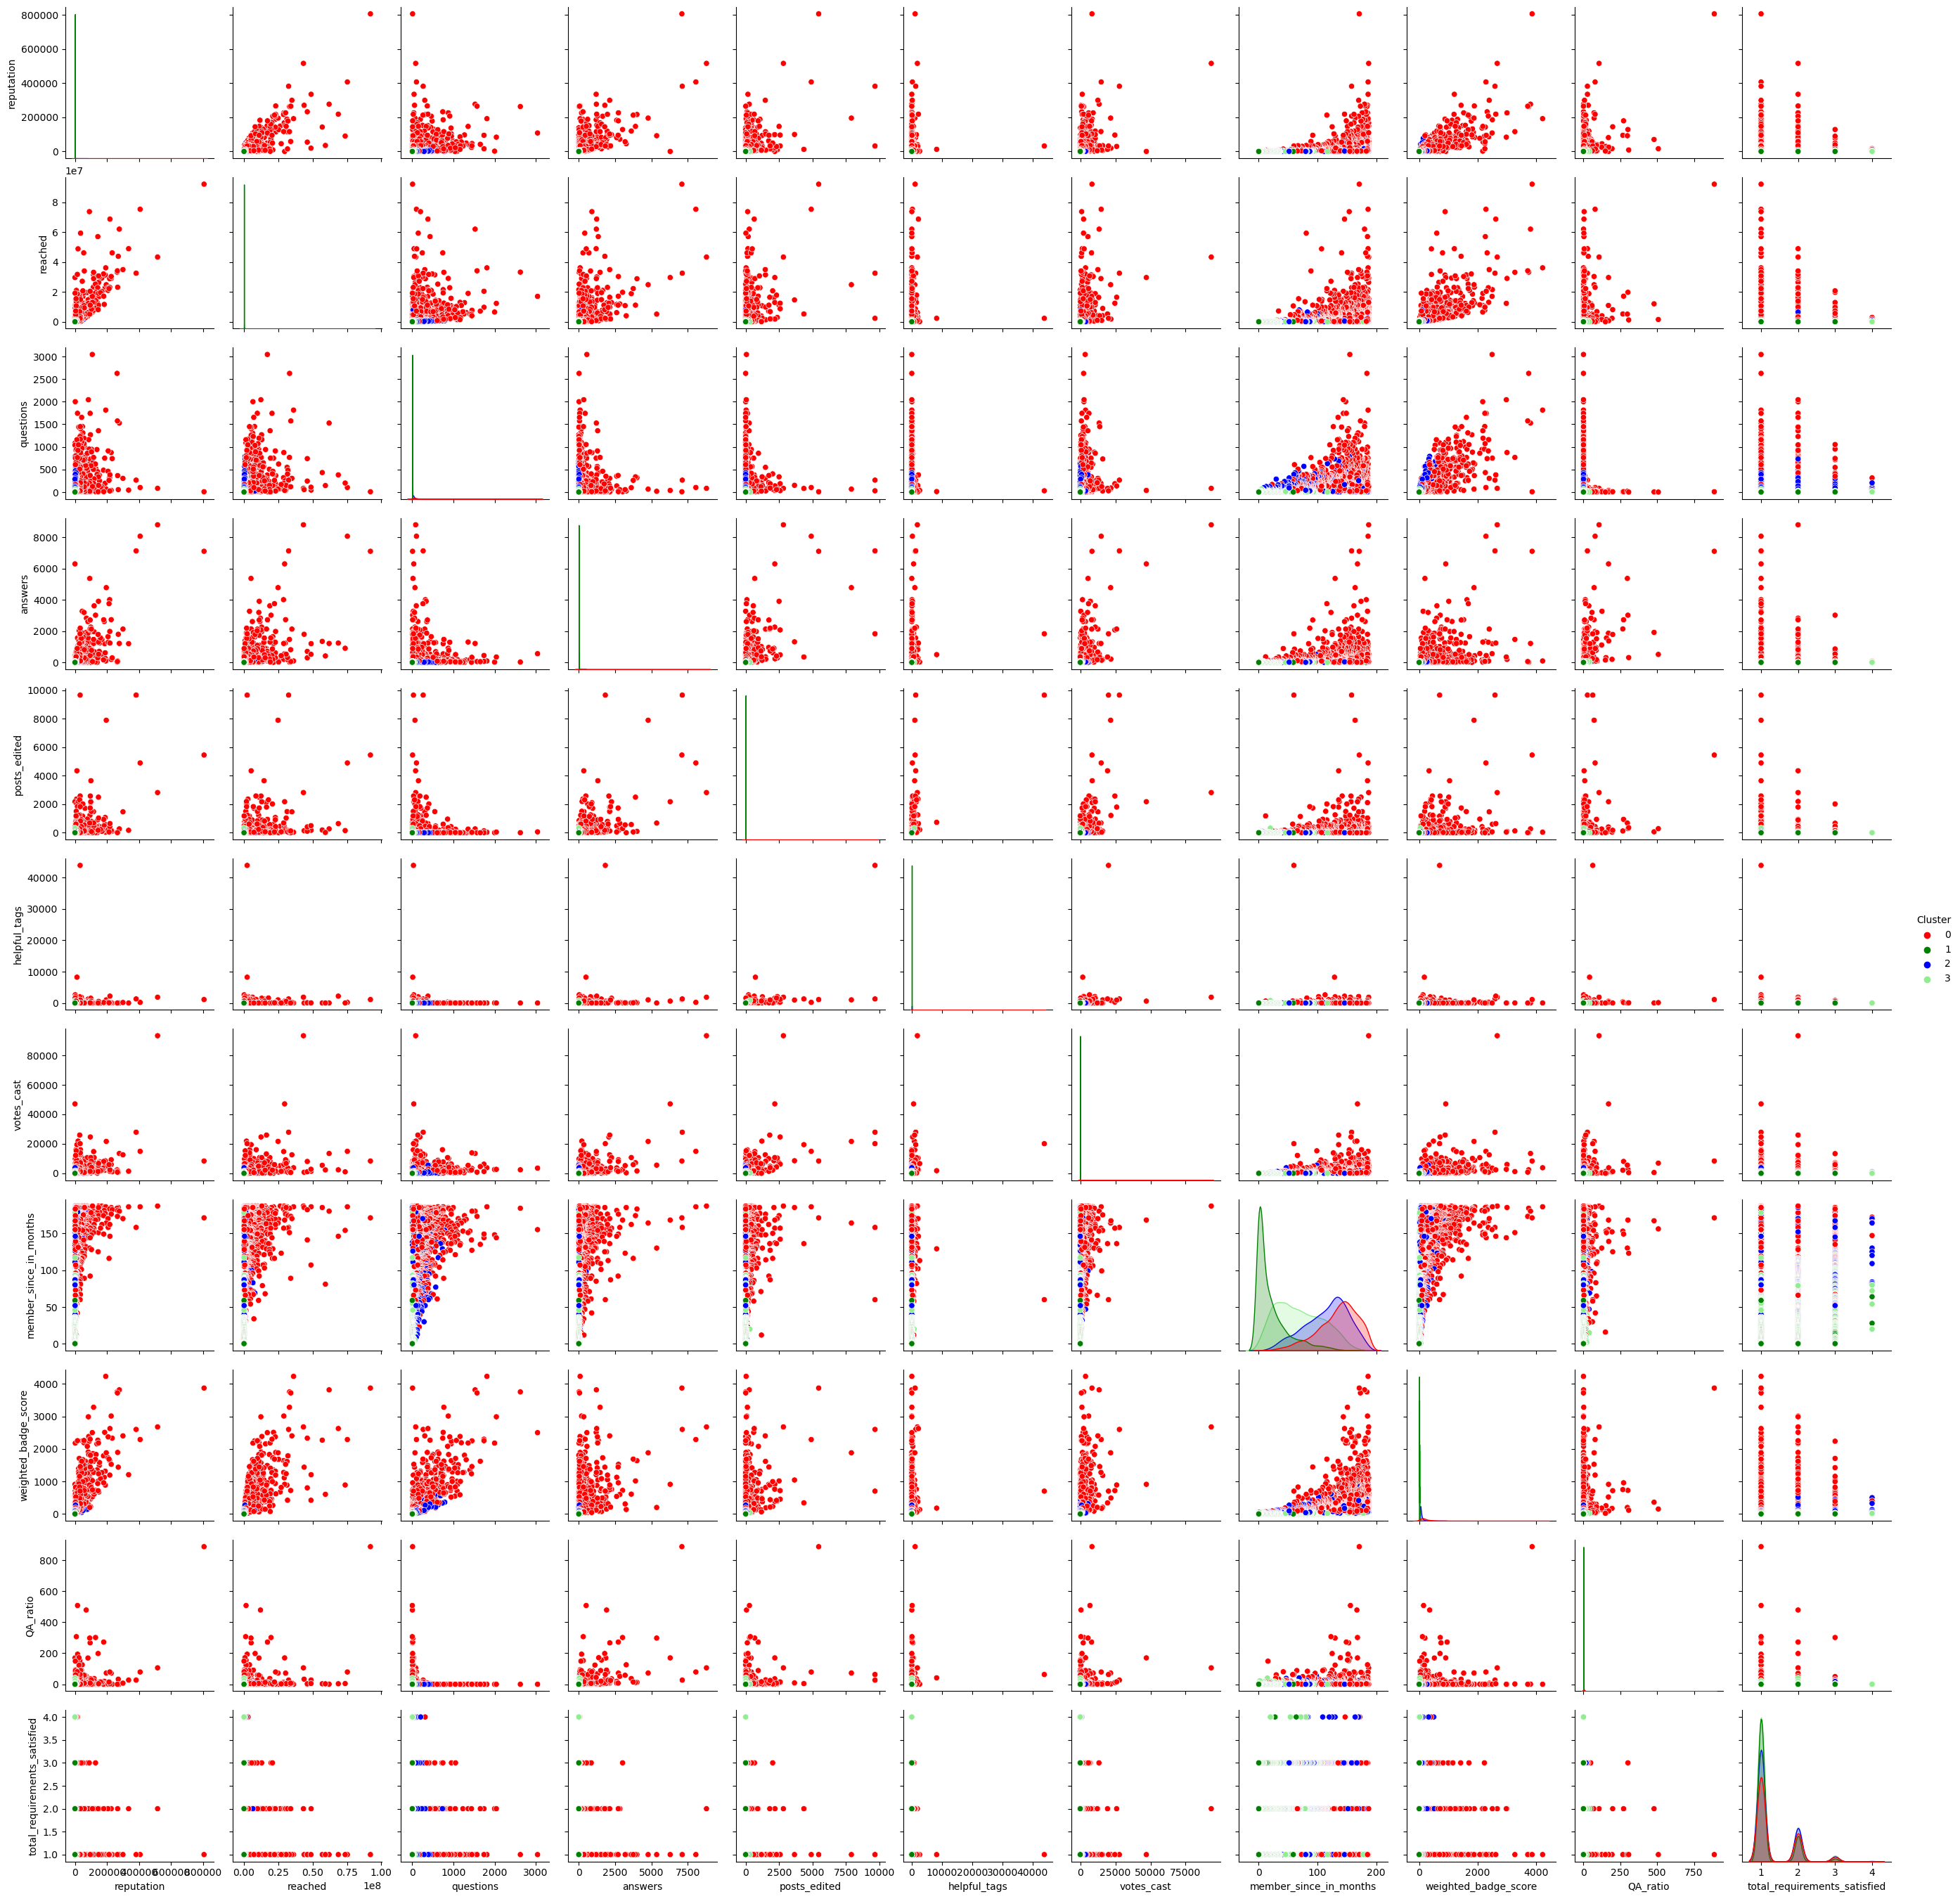

In [55]:
import seaborn as sns
palette = {0: "red", 1: "green", 2: "blue", 3: "lightgreen"} 
sns.pairplot(kmodel_inference, hue='Cluster', palette = palette)
plt.show()

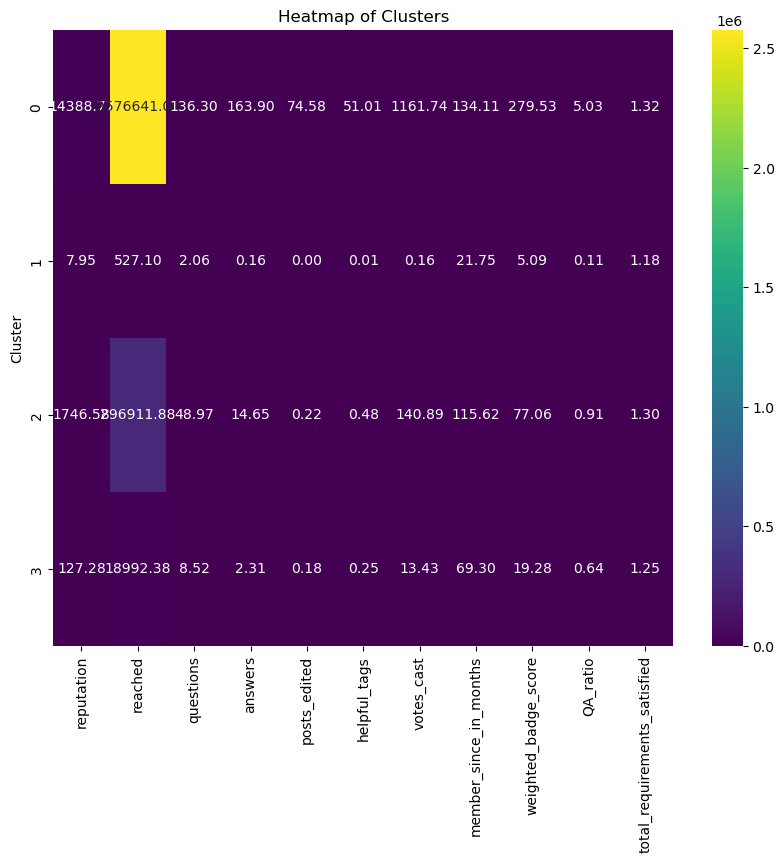

In [56]:
corr_matrix = kmodel_inference.groupby('Cluster').mean().round(2)
corr_matrix.sort_values(by='Cluster',inplace=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap = 'viridis')
plt.title('Heatmap of Clusters')
plt.show()

## TESTING

In [57]:
#Cleaning the data
df_test['name'] = df_test['name'].str.replace('\n','')
df_test['name'] = df_test['name'].str.strip()

#Null Value Imputation
df_test['job_role'].fillna('NA',inplace=True)
df_test['tags'].fillna('NA',inplace=True)
df_test['gold_badges'].fillna('NA',inplace=True)
df_test['silver_badges'].fillna('0',inplace=True)
df_test['bronze_badges'].fillna('0',inplace=True)
df_test['questions'].fillna('0',inplace=True)
df_test['answers'].fillna('0',inplace=True)
df_test['reputation'].fillna('0',inplace=True)
df_test['reached'].fillna('0',inplace=True)
df_test['posts_edited'].fillna('0',inplace=True)
df_test['votes_cast'].fillna('0',inplace=True)
df_test['helpful_tags'].fillna('0',inplace=True)

df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']]=df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

# 2. Clean k and m values
df_test['reached'] = df_test['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_test['reached'] = df_test['reached'].apply(convert_k_to_num)

# 3. Cleaning Member_Since
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_test['member_since_in_months'] = df_test['member_since'].apply(convert_to_months)
df_test['member_since_in_months'] = df_test['member_since_in_months'].round(2)

#Type Casting
df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

#Feature Engineering
df_test['weighted_badge_score'] = (3 * df_test['gold_badges']) + (2 * df_test['silver_badges']) + df_test['bronze_badges']
df_test['questions'] = np.where(df_test['questions']==0, 1, df_test['questions'])
df_test['QA_ratio'] = (df_test['answers']/df_test['questions']).round(2)

#dropping this because there's a weighted badge score
df_test.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

#Creating flags
df_test['Programming_Language_Flag'] = np.where(df_test['tags'].apply(lambda x:'java' in x),1,0)
df_test['DBMS_Flag'] = np.where(df_test['tags'].str.contains('sql'),1,0)
df_test['Web_Dev_Flag'] = np.where(df_test['tags'].str.contains('spring|hibernate'),1,0)
df_test['Other_Skills_Flag'] = np.where(df_test['tags'].str.contains('maven|gradle|ant|git|svn|mercurial|junit|mockito|testng|selenium'),1,0)
df_test['Programming_Language_Flag'] = np.where(df_test['Web_Dev_Flag']==1, 1, df_test['Programming_Language_Flag'])
df_test['total_requirements_satisfied'] = df_test['Programming_Language_Flag']+df_test['DBMS_Flag']+df_test['Web_Dev_Flag']+df_test['Other_Skills_Flag']

#Shortlisting Candidates with Valid Skill
df_test = df_test[df_test['total_requirements_satisfied']>=1]

#Transformations
df_test['reputation_st'],rep = st.boxcox(df_test['reputation']+1)
df_test['reached_st'],reach = st.boxcox(df_test['reached']+1)
df_test['questions_st'],ques = st.boxcox(df_test['questions']+1)
df_test['answers_st'],ans = st.boxcox(df_test['answers']+1)
df_test['posts_edited_st'],post = st.boxcox(df_test['posts_edited']+1)
df_test['helpful_tags_st'],help = st.boxcox(df_test['helpful_tags']+1)
df_test['votes_cast_st'],vote = st.boxcox(df_test['votes_cast']+1)
df_test['weighted_badge_score_st'],badge = st.boxcox(df_test['weighted_badge_score']+1)
df_test['QA_ratio_st'] = df_test['QA_ratio']**0.2

#Scaling with Robust Scaler
st_columns = [i for i in df_test.columns if i.endswith('_st')]
scaler = RobustScaler()
df_test[st_columns] = scaler.fit_transform(df_test[st_columns])
scaled2 = scaler.fit_transform(df_test[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_test.index)
df_test = pd.concat([df_test, df_scaled2], axis=1)
st_columns1 = [i for i in df_test.columns if i.endswith('_st')]

df_test['Cluster'] = kmeans.predict(df_test[st_columns1])
testing_inference = df_test[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [58]:
testing_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0          15384.87  2696232.63     133.73   168.85        314.39   
1              7.74      576.68       2.04     0.16          0.00   
2           1916.19   330952.76      52.17    17.29          0.17   
3            132.27    21835.88       8.79     2.28          0.11   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0               52.97     1303.40                  134.94   
1                0.01        0.14                   21.57   
2                0.55      147.82                  116.63   
3                0.07       14.86                   67.75   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                      280.88      4.52                          1.30  
1                        5.21      0.11                          1.19  
2                       82.15      1.15                          1.32  
3                       19.60      0.67                          1.25

In [59]:
testing_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        3              1382
1        2              1122
2        1              1002
3        0               950

## Validation

In [60]:
from sklearn.metrics import silhouette_score

# Combine the training and testing data for a comprehensive silhouette analysis
combined = np.vstack((kmodel[st_columns1], df_test[st_columns1]))
clusters_combined = np.concatenate((kmodel['Cluster'], df_test['Cluster']))

# Compute the silhouette score
silhouette_avg = silhouette_score(combined, clusters_combined)
print('Combined Silhouette Score:', silhouette_avg)

Combined Silhouette Score: 0.26519427489279096


In [61]:
dir_path = './model_pickle_files'

# Define the complete file path including the name of the pickle file
file_path = os.path.join(dir_path, 'java-developer-model.pkl')

# Ensure the directory exists, create if it doesn't
os.makedirs(dir_path, exist_ok=True)

# Save the model as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(kmeans, file)

print(f"Model saved successfully at {file_path}")

Model saved successfully at ./model_pickle_files/java-developer-model.pkl
